In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
import h5py
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

In [19]:
def collect_data(filename):
    
    # Open the file
    with h5py.File(filename, 'r') as f:
        # locs
        locs = f['locs']
        
        x_values = locs['x'][:]
        y_values = locs['y'][:]
        
    data = {
        'x': x_values,
        'y': y_values,
    }
    
    return pd.DataFrame(data)

def collect_group_data(hdf5_file, dataset_name):
    group_data_list = []

    with h5py.File(hdf5_file, 'r') as f:
        # Access the dataset
        dataset = f[dataset_name]

        # Extract the 'group', 'x', and 'y' fields
        group_data = dataset['group'][:]
        x_data = dataset['x'][:]
        y_data = dataset['y'][:]

        # Find unique groups
        unique_groups = np.unique(group_data)

        # Collect data for each group
        for group in unique_groups:
            indices = np.where(group_data == group)
            group_dict = {
                'group': int(group),
                'x': x_data[indices].tolist(),
                'y': y_data[indices].tolist()
            }
            group_data_list.append(group_dict)
    
    return group_data_list

def dbscan_filter(data, eps=0.05, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples,).fit(data)

    # Get core sample indices
    core_samples = clustering.core_sample_indices_

    return data.iloc[core_samples]

def find_clusters_k_means(data, k):
    kmeans = KMeans(init="k-means++", n_clusters=k, tol=1e-8, n_init=8, max_iter=1000)
    kmeans.fit(data)
    return kmeans.labels_

def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.
    """
    pi2 = np.pi / 2

    # Get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # Calculate edge angles
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # Find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)
    ]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # Find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # Find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # Return the best box
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def distance_to_line(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))

def find_closest_side(points, rectangle):
    distances = []
    for i in range(4):
        line_start = rectangle[i]
        line_end = rectangle[(i + 1) % 4]
        distances.append(np.mean([distance_to_line(point, line_start, line_end) for point in points]))
    closest_side = np.argmin(distances)
    return closest_side

def find_rotation_angle(rectangle, closest_side):
    # Find the angle of the closest side to make it parallel to the x-axis
    closest_line_start = rectangle[closest_side]
    closest_line_end = rectangle[(closest_side + 1) % 4]
    
    # Debugging: Print the coordinates of the closest line
    print(f"Closest line start: {closest_line_start}, end: {closest_line_end}")
    
    angle = np.arctan2(closest_line_end[1] - closest_line_start[1], closest_line_end[0] - closest_line_start[0])
    
    # Debugging: Print the initial calculated angle
    print(f"Initial calculated angle: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Ensure the longer side is at the top (if not, adjust the angle by 90 degrees)
    if rectangle[1][0] < rectangle[1][1]:
        angle += np.pi / 2
        print(f"Adjusted angle by 90 degrees: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Determine if the closest edge is the top or bottom edge
    if closest_line_start[1] < closest_line_end[1]:  # If the closest side is the bottom side
        angle += np.pi  # Rotate by 180 degrees to move it to the top
        print(f"Adjusted angle by 180 degrees (for bottom side): {angle} radians ({np.degrees(angle)} degrees)")
    
    final_angle = -angle  # Negate to rotate in the correct direction
    
    # Debugging: Print the final rotation angle
    print(f"Final rotation angle: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    return final_angle

def adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side):
    """
    Adjust the final orientation of the image by comparing the y-values of the closest side 
    before and after rotating by an additional 180 degrees.
    """
    # Calculate the y-values of the closest edge
    closest_line_start = rotated_rect[closest_side]
    closest_line_end = rotated_rect[(closest_side + 1) % 4]
    avg_y_before = (closest_line_start[1] + closest_line_end[1]) / 2
    
    # Perform a 180-degree rotation
    rotated_data_180 = rotate_points(rotated_com, np.pi, find_center_of_rectangle(rotated_rect))
    rotated_rect_180 = rotate_points(rotated_rect, np.pi, find_center_of_rectangle(rotated_rect))
    
    # Calculate the y-values of the rotated edge after the 180-degree rotation
    closest_line_start_180 = rotated_rect_180[closest_side]
    closest_line_end_180 = rotated_rect_180[(closest_side + 1) % 4]
    avg_y_after = (closest_line_start_180[1] + closest_line_end_180[1]) / 2
    
    # Compare the average y-values and choose the orientation with the higher y-value
    if avg_y_after < avg_y_before:
        print("Adjusting by 180 degrees")
        return rotated_data_180, rotated_rect_180, rotation_angle + np.pi
    else:
        return rotated_com, rotated_rect, rotation_angle

def rotate_points(points, rotation_angle, pivot):
    """
    Rotate the given points around the pivot by the given rotation angle.
    """
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])
    rotated_points = np.dot(points - pivot, rotation_matrix.T) + pivot
    return rotated_points

def find_middle_left_most_com(rotated_com):
    # Sort each com in rotated_com based on its x value and take the first 3
    sorted_com = rotated_com[rotated_com[:, 0].argsort()][:3]
    second_highest_com = None
    
    # Find the second highest y value in sorted_com
    for com in sorted_com:
        if com[1] != max(sorted_com[:, 1]) and com[1] != min(sorted_com[:, 1]):
            second_highest_com = com
            break
    return second_highest_com

def find_right_most_coms(rotated_com):
    # Sort each com in rotated_com based on its x value
    sorted_com = rotated_com[rotated_com[:, 0].argsort()]
    right_most_com = sorted_com[-1]
    second_right_most_com = sorted_com[-2]
    return right_most_com, second_right_most_com

def find_center_of_rectangle(rectangle):
    return np.mean(rectangle, axis=0)

def find_robot(rotated_com):
    """
    Find the COM (center of mass) that is closest to the geometric center
    of all COMs, effectively making it the central COM within the origami.
    """
    
    # Calculate the centroid (geometric center) of all COM points
    geometric_center = np.mean(rotated_com, axis=0)
    
    # Calculate the distances of each COM to the geometric center
    distances = np.linalg.norm(rotated_com - geometric_center, axis=1)
    
    # Find the index of the COM closest to the geometric center
    closest_com_index = np.argmin(distances)
    
    # Return the COM that is closest to the geometric center
    closest_com = rotated_com[closest_com_index]
    
    return closest_com

def draw_line_between_points(p1, p2, color='white'):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    
def intersection_between_point_line(point, line):
    x0, y0 = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    if x1 == x2:
        return x1, y0
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    x = (m * y0 + x0 - m * c) / (m ** 2 + 1)
    y = m * x + c
    return x, y

def draw_line_between_point_and_line( p1, p2, p3):
    
    #finding the intersection point
    right_line = np.array([p1, p2])
    intersection_x, intersection_y = intersection_between_point_line(p3, right_line)
    intersection_point = np.array([intersection_x, intersection_y])
    
    #plotting the points between the points p3 and intersection point
    plt.plot([p3[0], intersection_point[0]], [p3[1], intersection_point[1]], color='magenta')

def calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com):
    def distance_point_to_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

    right_line = np.array([right_most_com, second_right_most_com])
    intersection_point = intersection_between_point_line(robot_com, right_line)
    normalizing_point = intersection_between_point_line(second_highest_com, right_line)
    robot_distance = distance_point_to_line(robot_com, right_line)
    normalizing_distance = distance_point_to_line(second_highest_com, right_line)
    ratio = robot_distance / normalizing_distance

    plt.axes().set_facecolor('black')
    ax = plt.gca()
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=10)
    plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=10)
    plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=10)
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=10)
    plt.scatter(robot_com[0], robot_com[1], color='magenta', s=10)

    draw_line_between_points(right_most_com, second_right_most_com, color='magenta')
    draw_line_between_point_and_line(right_most_com, second_right_most_com, robot_com)
    draw_line_between_point_and_line(second_right_most_com, right_most_com, second_highest_com)

    plt.grid(False)
    plt.show()

    return ratio


In [5]:
def plot_helper(data=None, labels=None, com=None, rotated_data=None, rotated_com=None, rotated_rect=None, second_highest_com=None, right_most_com=None, second_right_most_com=None, robot_com=None, title="Plot"):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    
    if data is not None and labels is not None:
        plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
    elif data is not None:
        plt.scatter(data['x'], data['y'], s=10, alpha=0.5)
    
    if com is not None and len(com) > 0:
        com = np.array(com)
        plt.scatter(com[:, 0], com[:, 1], c='red', s=100, label='COMs')
    
    if rotated_data is not None and rotated_data.size > 0:
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    
    if rotated_com is not None and rotated_com.size > 0:
        plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=100, label='Rotated COMs')
   
    if rotated_rect is not None and rotated_rect.size > 0:
        for i in range(4):
            plt.plot([rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                     [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 'b-')

    if second_highest_com is not None and len(second_highest_com) > 0:
        plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=100, label='Second Highest COM')
    

    if right_most_com is not None and len(right_most_com) > 0:
        plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=100, label='Right Most COM')
   
    if second_right_most_com is not None and len(second_right_most_com) > 0:
        plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=100, label='Second Right Most COM')
    
    if robot_com is not None and len(robot_com) > 0:
        plt.scatter(robot_com[0], robot_com[1], color='magenta', s=100, label='Robot COM')
    
    
    plt.title(title)
    plt.grid(False)
    plt.legend()
    plt.show()




def process_origami_ratio(filename, k):
    print("Starting process_origami_ratio")
    
    data = collect_data(filename)
    print("Data collected:\n", data.head())
    plot_helper(data=data, title="Initial Data")
    
    labels = find_clusters_k_means(data, k)
    print("K-Means labels:\n", labels)
    plot_helper(data=data, labels=labels, title="K-Means Clustering")

    com = find_com(data, labels)
    print("Centers of Mass (COM):\n", com)
    plot_helper(data=data, labels=labels, com=com, title="Centers of Mass")

    min_bounding_rect = minimum_bounding_rectangle(np.array(com))
    print("Minimum Bounding Rectangle:\n", min_bounding_rect)
    
    closest_side = find_closest_side(np.array(com), min_bounding_rect)
    print("Closest side of bounding rectangle:\n", closest_side)
    
    rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
    print("Rotation angle:\n", rotation_angle)
    
    rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Data:\n", rotated_data[:5])
    
    rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Centers of Mass (COM):\n", rotated_com)
    
    rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
    
    # Adjust the final orientation if needed
    rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
    if (rotation_angle != final_angle):
        #totae the data points by 180 degrees
        rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
    print(f"Final rotation angle after adjustment: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title="Final Adjusted Data and COMs")

    second_highest_com = find_middle_left_most_com(rotated_com)
    print("Second Highest COM:\n", second_highest_com)
    
    right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
    print("Right Most COM:\n", right_most_com)
    print("Second Right Most COM:\n", second_right_most_com)
    
    robot_com = find_robot(rotated_com)
    print("Robot COM:\n", robot_com)

    ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
    print("Ratio:\n", ratio)
    
    

    return ratio


In [7]:
def generate_ratio_histogram(ratios, bins=10, title="Histogram of Ratios", xlabel="Ratio", ylabel="Frequency"):
    """
    Generates a histogram of the provided ratios.
    
    :param ratios: List of ratio values to plot.
    :param bins: Number of bins for the histogram.
    :param title: Title of the histogram plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.hist(ratios, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    

def plot_ratio_points_and_lines(ratios, title="Points and Lines Plot of Ratios", xlabel="Index", ylabel="Ratio"):
    """
    Plots points for each ratio and connects them with lines to visualize peaks.
    
    :param ratios: List of ratio values to plot.
    :param title: Title of the plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(20, 12))
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Plotting the points
    plt.plot(range(len(ratios)), ratios, 'o-', color='red', markersize=8, linewidth=2)
    
    # Annotate the peak points
    for i, ratio in enumerate(ratios):
        plt.annotate(f"{ratio:.6f}", (i, ratio), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


def process_multiple_origami_ratio(filename, k, flipped=False):
    # Collect data for each group
    group_data_list = collect_group_data(filename, 'locs')
    
    ratios = []  # List to store the ratios for each group
    
    # Process each group
    for group_data in group_data_list:
        data = pd.DataFrame({
            'x': group_data['x'],
            'y': group_data['y']
        })
        
        # Perform clustering and find centers of mass
        data = dbscan_filter(data)
        labels = find_clusters_k_means(data, k)
        com = find_com(data, labels)
    
        # Find the minimum bounding rectangle for the centers of mass
        min_bounding_rect = minimum_bounding_rectangle(np.array(com))
        
        # Identify the closest side of the bounding rectangle
        closest_side = find_closest_side(np.array(com), min_bounding_rect)
        
        # Determine the rotation angle to align the rectangle
        rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
        
        # Rotate the data points and centers of mass around the closest side
        rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
        rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
        rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
        
        # Adjust the final orientation if needed
        rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
        if rotation_angle != final_angle:
            # Rotate the data points by 180 degrees
            rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
        # Apply flipping transformation after orientation adjustments if flipped is True
        if flipped:
            rotated_data[:, 0] = -rotated_data[:, 0]  # Flip x-coordinates of data
            rotated_com[:, 0] = -rotated_com[:, 0]  # Flip x-coordinates of centers of mass (COM)
        
        # Locate the second highest and right-most centers of mass for the ratio calculation
        second_highest_com = find_middle_left_most_com(rotated_com)
        right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
        robot_com = find_robot(rotated_com)
    
        # Calculate the ratio using distances from the centers of mass
        ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
        ratios.append(ratio)  # Store the ratio for this group
    
    # Generate a histogram of all the collected ratios
    generate_ratio_histogram(ratios)  
    
    # Sort ratios to make the point line plot resemble a Gaussian curve
    ratios.sort()
    
    # Plot the points and lines for the sorted ratios
    plot_ratio_points_and_lines(ratios)  
    
    # Calculate the mean and standard deviation of the ratios
    mean_ratio = np.mean(ratios)
    std_dev = np.std(ratios)
    print(f"Mean Ratio: {mean_ratio}")
    print(f"Standard Deviation: {std_dev}")
    
    return ratios


<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\sbeeredd\AppData\Local\Temp\ipykernel_17044\1337855940.py:2: SyntaxWarning: invalid escape sequence '\c'
  filename = 'data\csdna_v8_no_inhibitor_1nM_20nm_grid_0.5nM_HM_t=0_82324_T3_locs_render_picked_refined.hdf5'


Closest line start: [56.85453839 12.22303279], end: [56.17828329 12.28677261]
Initial calculated angle: 3.0476161849110244 radians (174.6155449711632 degrees)
Adjusted angle by 180 degrees (for bottom side): 6.189208838500818 radians (354.6155449711632 degrees)
Final rotation angle: -6.189208838500818 radians (-354.6155449711632 degrees)


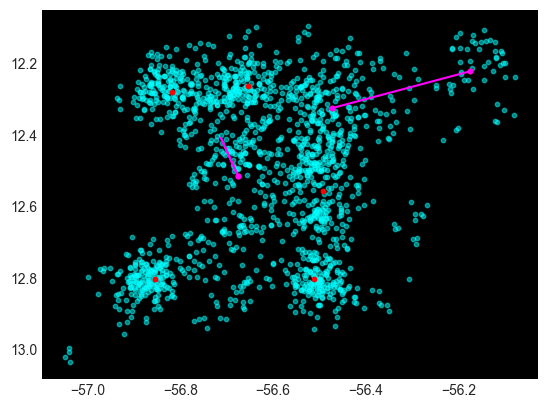

Closest line start: [70.05095476 13.85678228], end: [69.45523755 13.53759322]
Initial calculated angle: -2.649711941920192 radians (-151.81731119744052 degrees)
Final rotation angle: 2.649711941920192 radians (151.81731119744052 degrees)
Adjusting by 180 degrees


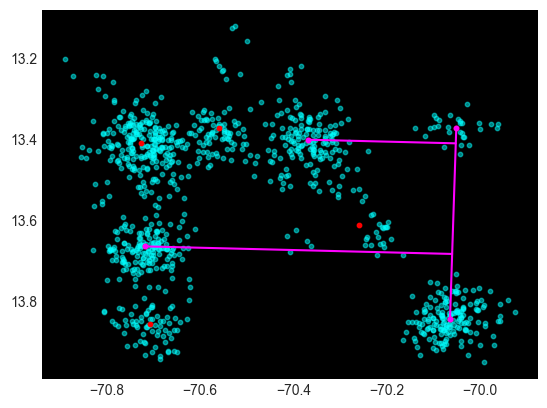

Closest line start: [81.84764693  8.18611546], end: [81.85055263  8.83045354]
Initial calculated angle: 1.566286772715809 radians (89.74162158378228 degrees)
Adjusted angle by 180 degrees (for bottom side): 4.7078794263056025 radians (269.7416215837823 degrees)
Final rotation angle: -4.7078794263056025 radians (-269.7416215837823 degrees)


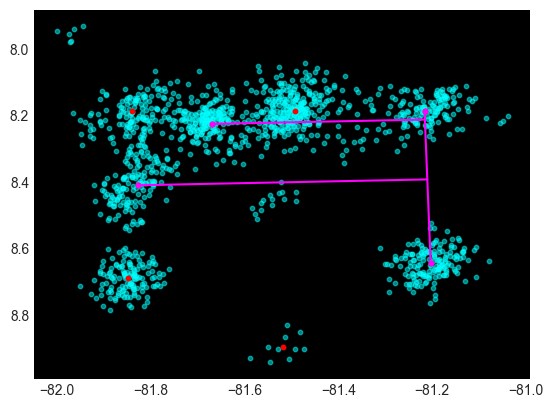

Closest line start: [226.47444433  11.36889354], end: [226.12422115  11.89231806]
Initial calculated angle: 2.160481442902046 radians (123.78646839462158 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.30207409649184 radians (303.78646839462164 degrees)
Final rotation angle: -5.30207409649184 radians (-303.78646839462164 degrees)


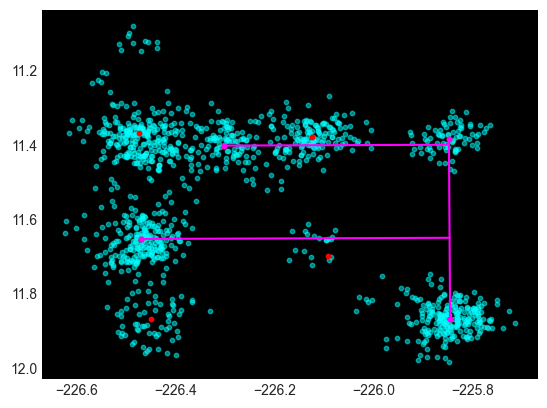

Closest line start: [24.1278107  24.50951717], end: [23.95931522 23.88154901]
Initial calculated angle: -1.8329402559441228 radians (-105.01974076522714 degrees)
Final rotation angle: 1.8329402559441228 radians (105.01974076522714 degrees)
Adjusting by 180 degrees


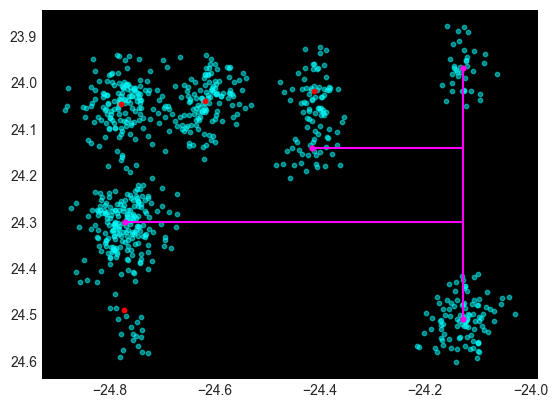

Closest line start: [167.50259627  34.91223206], end: [167.29665252  34.28125301]
Initial calculated angle: -1.8862827786610228 radians (-108.07604218548623 degrees)
Final rotation angle: 1.8862827786610228 radians (108.07604218548623 degrees)
Adjusting by 180 degrees


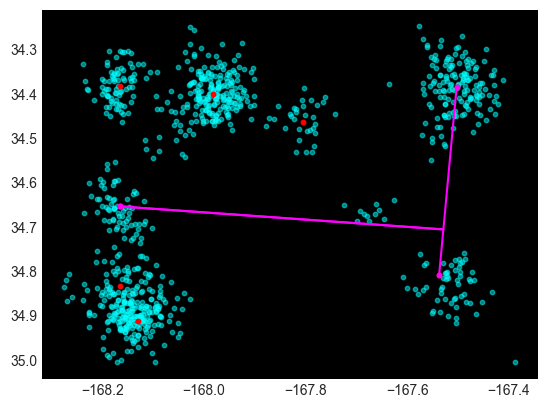

Closest line start: [215.77342501  27.73158017], end: [216.34555732  28.00345726]
Initial calculated angle: 0.44361124235264476 radians (25.417051931361662 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.585203895942438 radians (205.41705193136167 degrees)
Final rotation angle: -3.585203895942438 radians (-205.41705193136167 degrees)


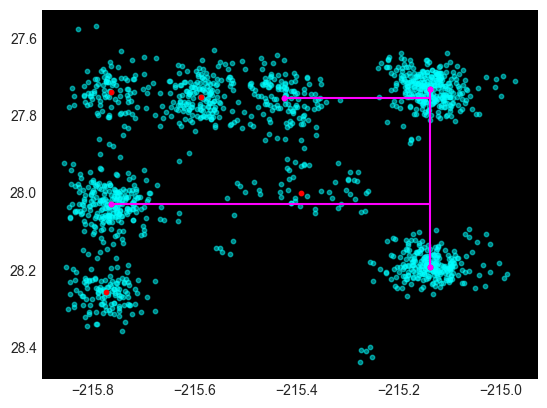

Closest line start: [223.053893   36.2414924], end: [222.73299402  36.8547366 ]
Initial calculated angle: 2.0528947332739578 radians (117.62220400123263 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.1944873868637504 radians (297.6222040012326 degrees)
Final rotation angle: -5.1944873868637504 radians (-297.6222040012326 degrees)


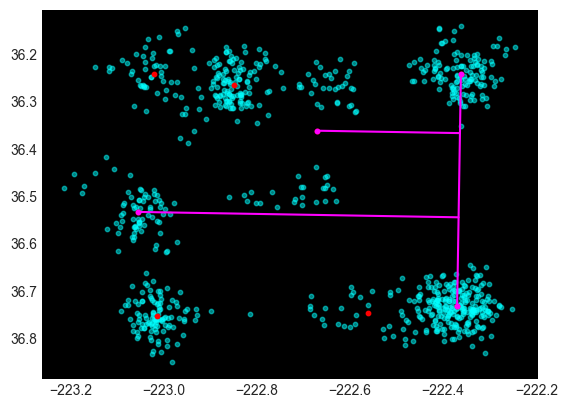

Closest line start: [177.52305716  39.3244867 ], end: [177.76376307  38.71090149]
Initial calculated angle: -1.196950486621089 radians (-68.5802111695185 degrees)
Final rotation angle: 1.196950486621089 radians (68.5802111695185 degrees)
Adjusting by 180 degrees


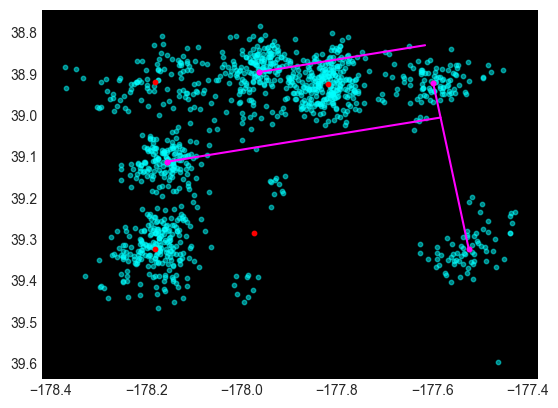

Closest line start: [170.81418569  45.23678826], end: [170.24660977  45.66848131]
Initial calculated angle: 2.491347789236934 radians (142.74371362252444 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.632940442826727 radians (322.74371362252447 degrees)
Final rotation angle: -5.632940442826727 radians (-322.74371362252447 degrees)


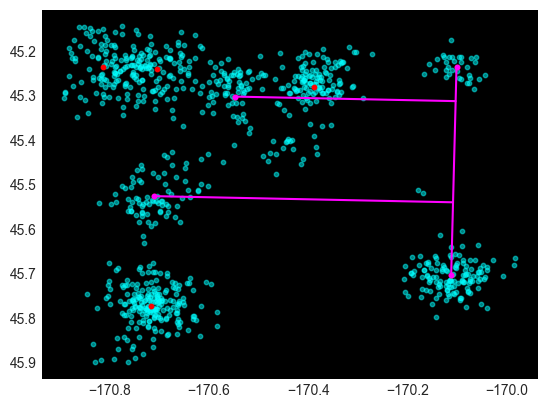

Closest line start: [62.92319673 41.06971898], end: [62.37444124 40.69169262]
Initial calculated angle: -2.5383692318665005 radians (-145.43784383181514 degrees)
Final rotation angle: 2.5383692318665005 radians (145.43784383181514 degrees)
Adjusting by 180 degrees


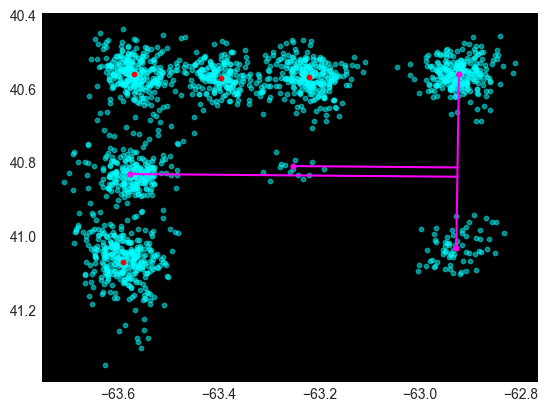

Closest line start: [26.0544608  37.56660004], end: [25.38799367 37.49124858]
Initial calculated angle: -3.0290097090863926 radians (-173.54947243479958 degrees)
Adjusted angle by 90 degrees: -1.458213382291496 radians (-83.54947243479958 degrees)
Final rotation angle: 1.458213382291496 radians (83.54947243479958 degrees)


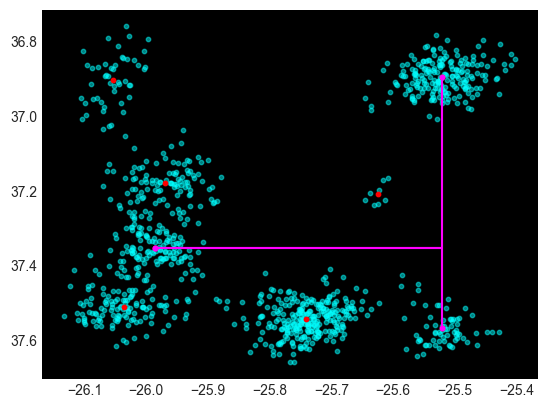

Closest line start: [24.63384797 40.68604059], end: [25.1328309  41.38971888]
Initial calculated angle: 0.9539846480308088 radians (54.65929405243867 degrees)
Adjusted angle by 90 degrees: 2.5247809748257053 radians (144.65929405243867 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.666373628415498 radians (324.65929405243867 degrees)
Final rotation angle: -5.666373628415498 radians (-324.65929405243867 degrees)


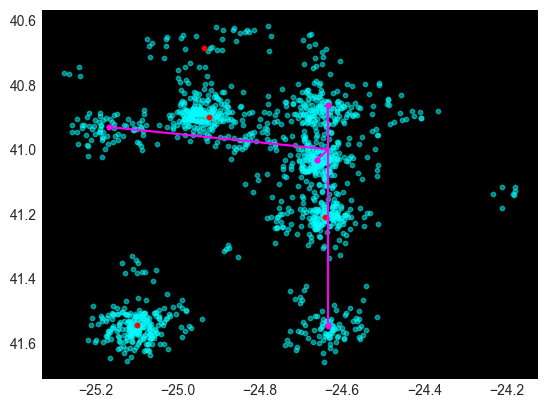

Closest line start: [24.38495073 40.08118081], end: [24.68429311 40.67170639]
Initial calculated angle: 1.1016372863686015 radians (63.11916706316572 degrees)
Adjusted angle by 90 degrees: 2.672433613163498 radians (153.11916706316572 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.814026266753292 radians (333.1191670631657 degrees)
Final rotation angle: -5.814026266753292 radians (-333.1191670631657 degrees)


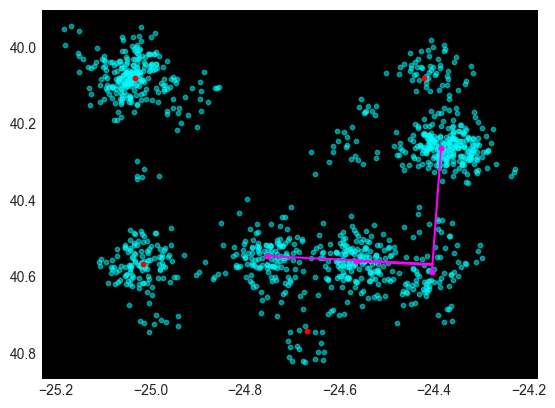

Closest line start: [34.30610148 46.84676612], end: [33.66068353 46.75620813]
Initial calculated angle: -3.00219360652421 radians (-172.01302293499657 degrees)
Adjusted angle by 90 degrees: -1.4313972797293135 radians (-82.01302293499657 degrees)
Final rotation angle: 1.4313972797293135 radians (82.01302293499657 degrees)


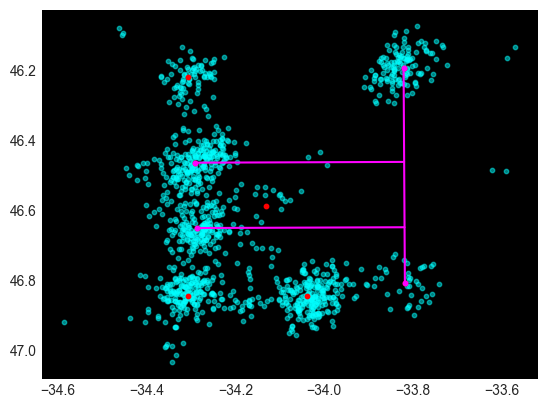

Closest line start: [71.82438916 54.20436561], end: [72.36916735 54.54957135]
Initial calculated angle: 0.5648046026704948 radians (32.360919982582736 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.706397256260288 radians (212.36091998258274 degrees)
Final rotation angle: -3.706397256260288 radians (-212.36091998258274 degrees)


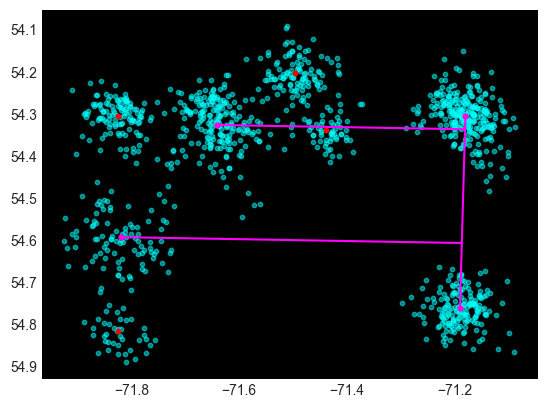

Closest line start: [82.57479941 46.78661543], end: [83.41060555 47.1784855 ]
Initial calculated angle: 0.43842085518278373 radians (25.11966465248977 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.580013508772577 radians (205.11966465248977 degrees)
Final rotation angle: -3.580013508772577 radians (-205.11966465248977 degrees)


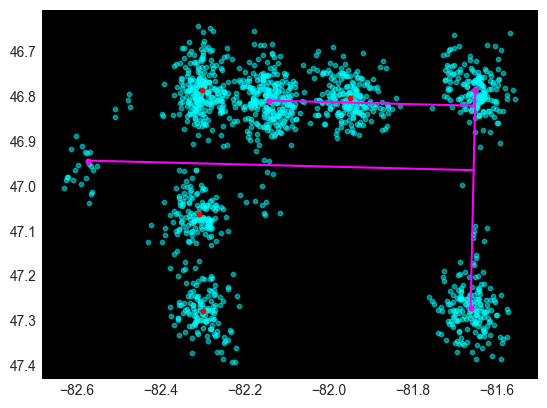

Closest line start: [134.87028371  44.85879461], end: [135.06563264  45.60539232]
Initial calculated angle: 1.314881315298529 radians (75.3371499272162 degrees)
Adjusted angle by 180 degrees (for bottom side): 4.456473968888322 radians (255.33714992721622 degrees)
Final rotation angle: -4.456473968888322 radians (-255.33714992721622 degrees)


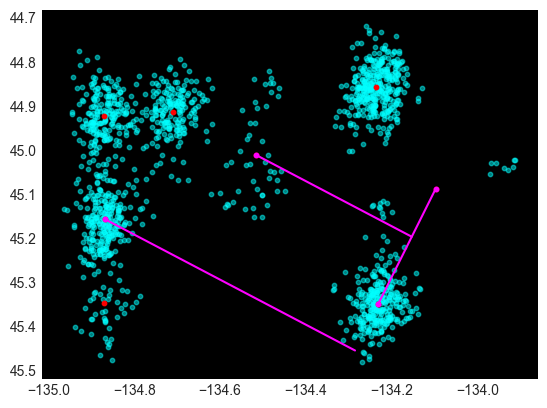

Closest line start: [131.39193469  55.24452797], end: [132.01895225  55.00530611]
Initial calculated angle: -0.364477512241932 radians (-20.883023178890497 degrees)
Final rotation angle: 0.364477512241932 radians (20.883023178890497 degrees)
Adjusting by 180 degrees


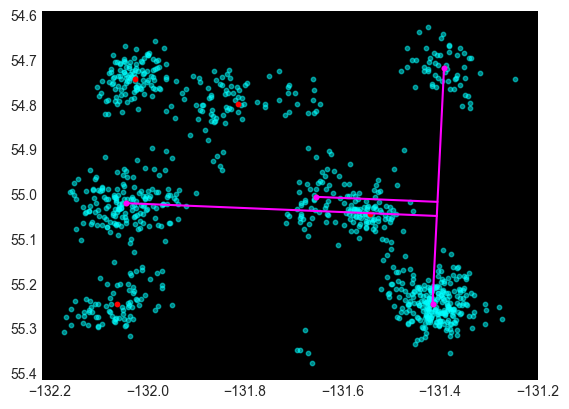

Closest line start: [166.95241076  48.67311179], end: [166.93296438  49.32576037]
Initial calculated angle: 1.6005836242557463 radians (91.70668642760744 degrees)
Adjusted angle by 180 degrees (for bottom side): 4.742176277845539 radians (271.70668642760745 degrees)
Final rotation angle: -4.742176277845539 radians (-271.70668642760745 degrees)


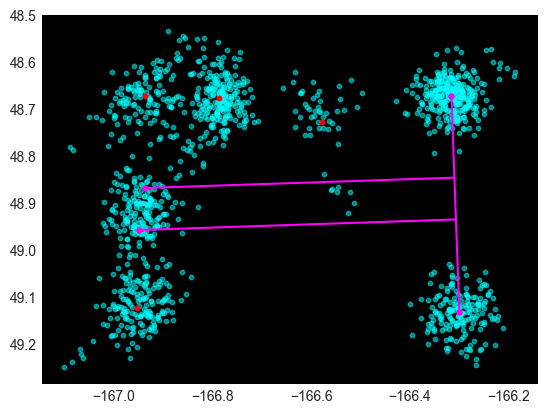

Closest line start: [174.21067707  57.19114506], end: [173.71860068  56.76040752]
Initial calculated angle: -2.4225662107360653 radians (-138.8028194661769 degrees)
Final rotation angle: 2.4225662107360653 radians (138.8028194661769 degrees)
Adjusting by 180 degrees


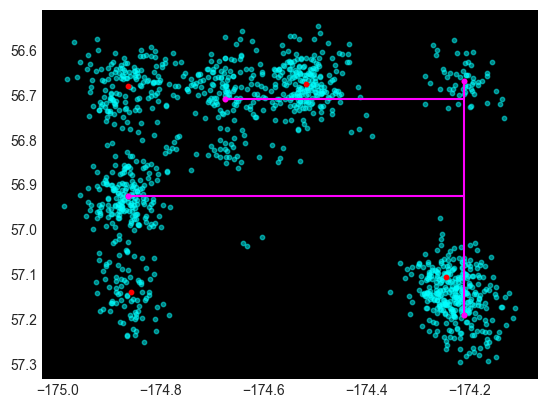

Closest line start: [181.78205944  47.15572738], end: [182.44524432  47.79222485]
Initial calculated angle: 0.7648672563939697 radians (43.82366567912509 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.906459909983763 radians (223.8236656791251 degrees)
Final rotation angle: -3.906459909983763 radians (-223.8236656791251 degrees)


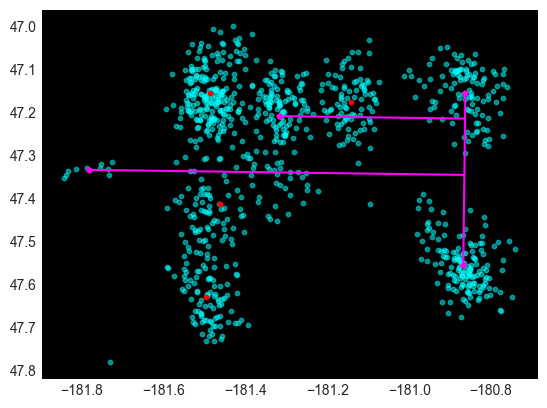

Closest line start: [218.4755287   53.40053191], end: [217.8345764   53.28316459]
Initial calculated angle: -2.9604851252073012 radians (-169.62330298563745 degrees)
Final rotation angle: 2.9604851252073012 radians (169.62330298563745 degrees)
Adjusting by 180 degrees


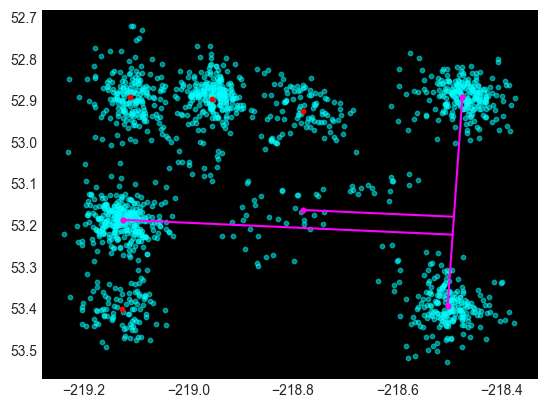

Closest line start: [226.1163569   47.88284922], end: [225.85732938  47.24978827]
Initial calculated angle: -1.9591800606930245 radians (-112.25274878389477 degrees)
Final rotation angle: 1.9591800606930245 radians (112.25274878389477 degrees)
Adjusting by 180 degrees


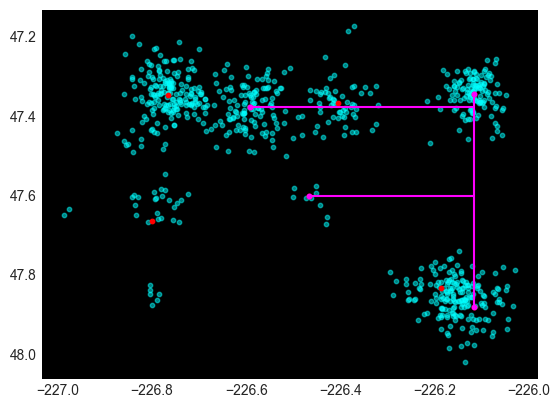

Closest line start: [247.80246834  46.09218605], end: [248.54691283  46.32069326]
Initial calculated angle: 0.297820653643216 radians (17.063866505583764 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.4394133072330093 radians (197.06386650558377 degrees)
Final rotation angle: -3.4394133072330093 radians (-197.06386650558377 degrees)


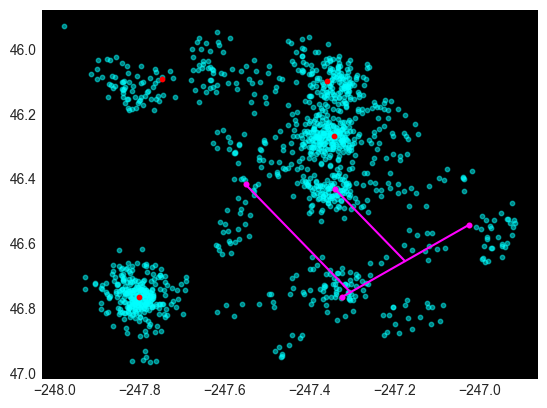

Closest line start: [235.15341862  68.19534016], end: [234.84969835  67.41602825]
Initial calculated angle: -1.9424169556373703 radians (-111.29229361267137 degrees)
Final rotation angle: 1.9424169556373703 radians (111.29229361267137 degrees)
Adjusting by 180 degrees


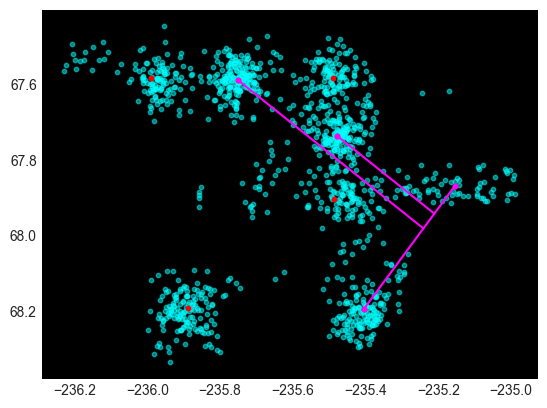

Closest line start: [212.40168292  67.33318674], end: [211.71685109  67.37506645]
Initial calculated angle: 3.080515438312084 radians (176.5005333401753 degrees)
Adjusted angle by 180 degrees (for bottom side): 6.222108091901877 radians (356.5005333401753 degrees)
Final rotation angle: -6.222108091901877 radians (-356.5005333401753 degrees)


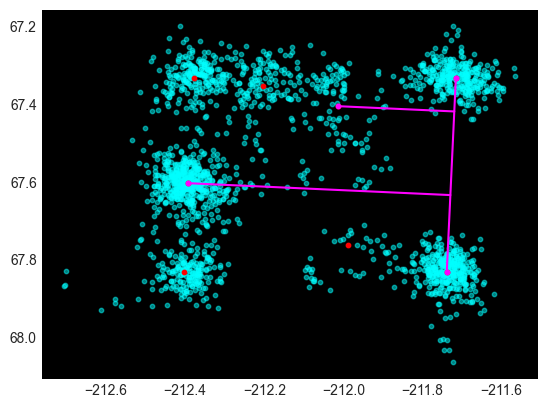

Closest line start: [206.47349553  67.45349268], end: [207.08586463  67.7068351 ]
Initial calculated angle: 0.3922680733869849 radians (22.475305042802283 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.533860726976778 radians (202.4753050428023 degrees)
Final rotation angle: -3.533860726976778 radians (-202.4753050428023 degrees)


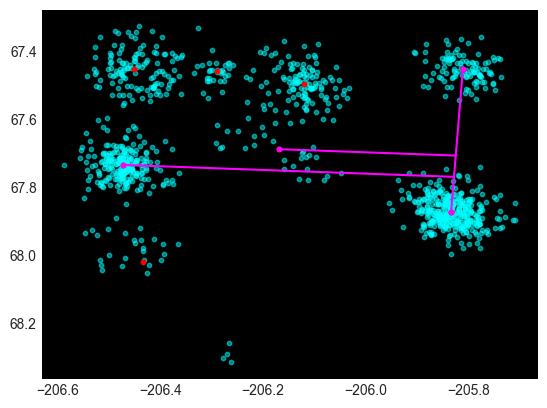

Closest line start: [214.88918458  63.53173663], end: [215.30555964  62.95562418]
Initial calculated angle: -0.9449761676163471 radians (-54.14314614486374 degrees)
Final rotation angle: 0.9449761676163471 radians (54.14314614486374 degrees)
Adjusting by 180 degrees


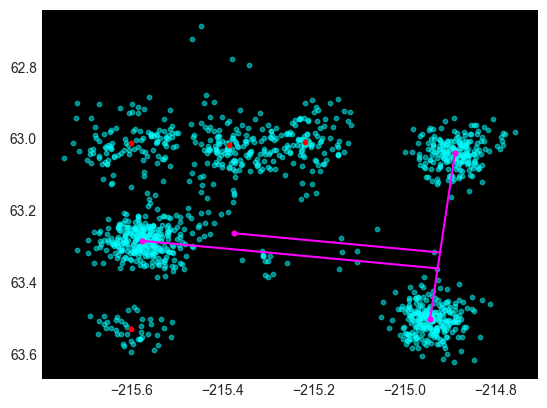

Closest line start: [188.1697304   64.17281142], end: [187.52021779  64.03788584]
Initial calculated angle: -2.936772140717217 radians (-168.26464905469643 degrees)
Final rotation angle: 2.936772140717217 radians (168.26464905469643 degrees)
Adjusting by 180 degrees


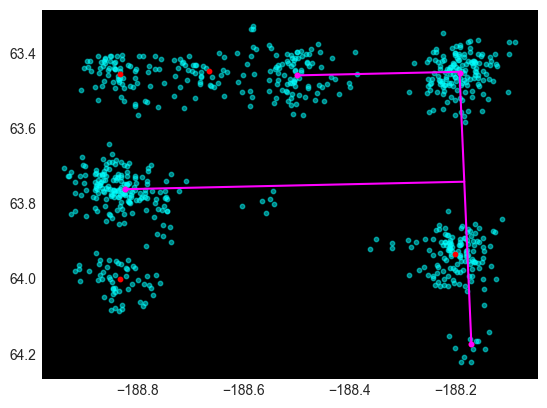

Closest line start: [121.10091935  64.61482742], end: [121.18794418  65.50376644]
Initial calculated angle: 1.4732098752587774 radians (84.40870818932243 degrees)
Adjusted angle by 180 degrees (for bottom side): 4.61480252884857 radians (264.4087081893224 degrees)
Final rotation angle: -4.61480252884857 radians (-264.4087081893224 degrees)


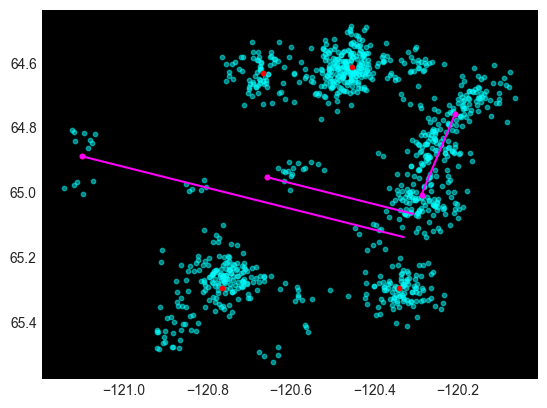

Closest line start: [63.64227947 69.80893008], end: [63.35639393 70.40584882]
Initial calculated angle: 2.017450720272257 radians (115.59141164722837 degrees)
Adjusted angle by 90 degrees: 3.5882470470671537 radians (205.59141164722837 degrees)
Adjusted angle by 180 degrees (for bottom side): 6.729839700656947 radians (385.59141164722837 degrees)
Final rotation angle: -6.729839700656947 radians (-385.59141164722837 degrees)


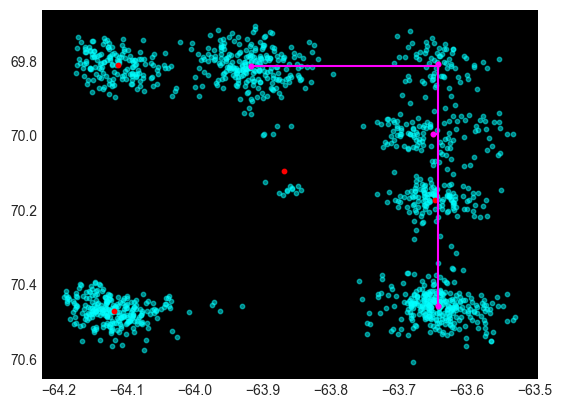

Closest line start: [72.68711289 73.41247582], end: [72.0326074  73.62021512]
Initial calculated angle: 2.8342510080032617 radians (162.3906208392862 degrees)
Adjusted angle by 90 degrees: 4.405047334798159 radians (252.39062083928624 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.546639988387952 radians (432.3906208392862 degrees)
Final rotation angle: -7.546639988387952 radians (-432.3906208392862 degrees)


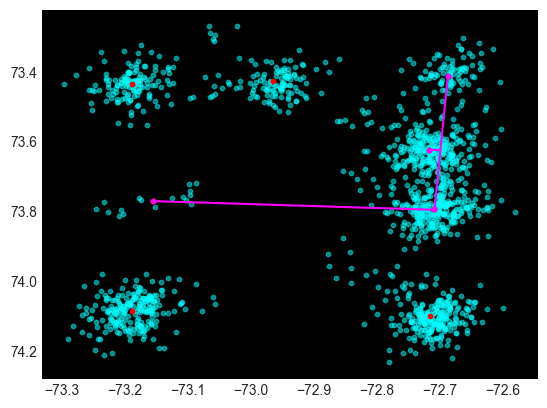

Closest line start: [123.57032702  68.658621  ], end: [122.69084108  68.71864836]
Initial calculated angle: 3.073445559000492 radians (176.09545909395425 degrees)
Adjusted angle by 180 degrees (for bottom side): 6.215038212590285 radians (356.0954590939542 degrees)
Final rotation angle: -6.215038212590285 radians (-356.0954590939542 degrees)


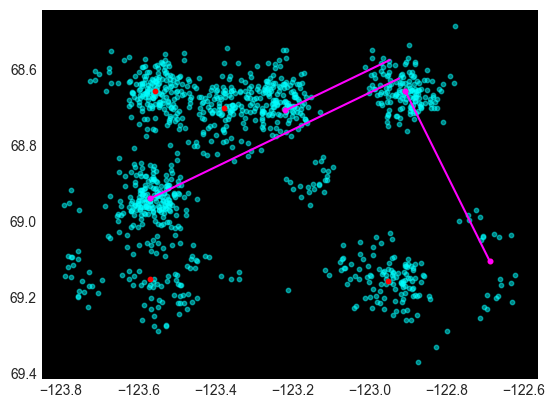

Closest line start: [202.72084941  78.23332855], end: [202.71647435  78.91178021]
Initial calculated angle: 1.5772448321938708 radians (90.36947214352855 degrees)
Adjusted angle by 180 degrees (for bottom side): 4.718837485783664 radians (270.3694721435285 degrees)
Final rotation angle: -4.718837485783664 radians (-270.3694721435285 degrees)


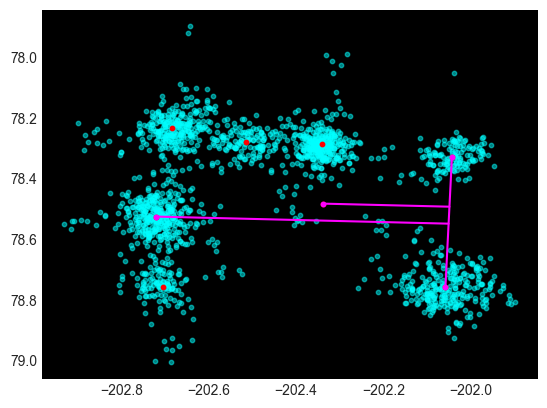

Closest line start: [214.39285261  70.48365185], end: [214.74032127  69.67048547]
Initial calculated angle: -1.1669764034253285 radians (-66.86282270762743 degrees)
Final rotation angle: 1.1669764034253285 radians (66.86282270762743 degrees)
Adjusting by 180 degrees


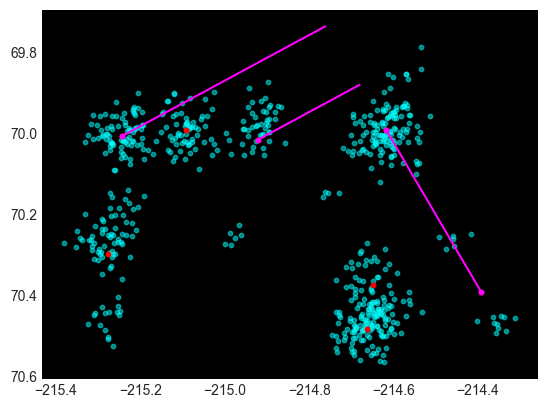

Closest line start: [249.40649884  96.40552844], end: [249.95088758  96.95652627]
Initial calculated angle: 0.7914316633887752 radians (45.345694085195255 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.9330243169785684 radians (225.34569408519525 degrees)
Final rotation angle: -3.9330243169785684 radians (-225.34569408519525 degrees)


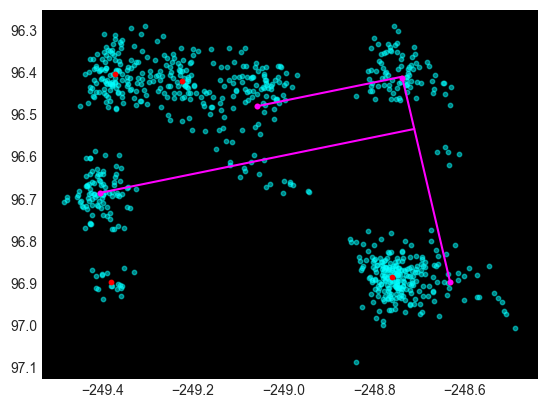

Closest line start: [239.47329973  99.63833723], end: [240.02871468  99.25016258]
Initial calculated angle: -0.6099814502154035 radians (-34.94936267861196 degrees)
Final rotation angle: 0.6099814502154035 radians (34.94936267861196 degrees)
Adjusting by 180 degrees


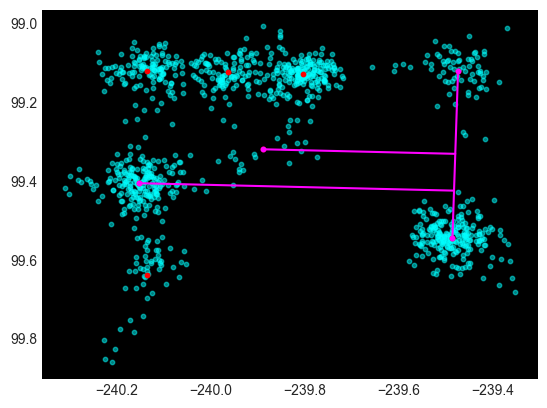

Closest line start: [165.40512079  97.97459299], end: [165.55548337  97.29993693]
Initial calculated angle: -1.3515073674012499 radians (-77.43566813292836 degrees)
Final rotation angle: 1.3515073674012499 radians (77.43566813292836 degrees)
Adjusting by 180 degrees


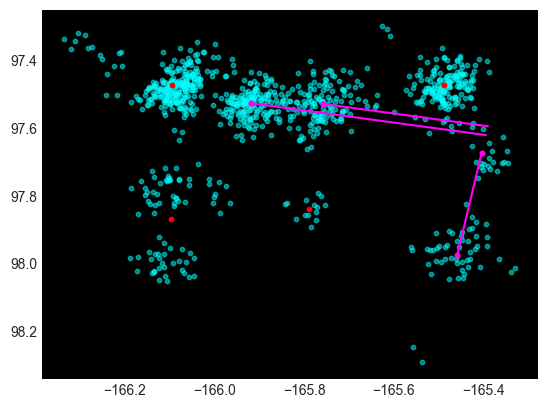

Closest line start: [129.2666565  95.0237041], end: [129.56949124  94.44084159]
Initial calculated angle: -1.091619811558507 radians (-62.54520803516869 degrees)
Final rotation angle: 1.091619811558507 radians (62.54520803516869 degrees)
Adjusting by 180 degrees


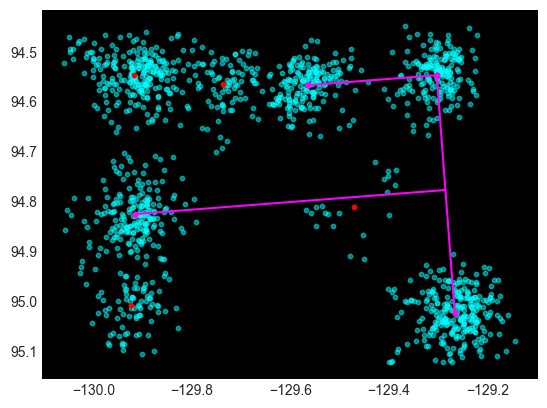

Closest line start: [88.3953757  89.27570865], end: [87.7778457  88.96538737]
Initial calculated angle: -2.6759309443274253 radians (-153.31954937841832 degrees)
Adjusted angle by 90 degrees: -1.1051346175325287 radians (-63.31954937841833 degrees)
Final rotation angle: 1.1051346175325287 radians (63.31954937841833 degrees)


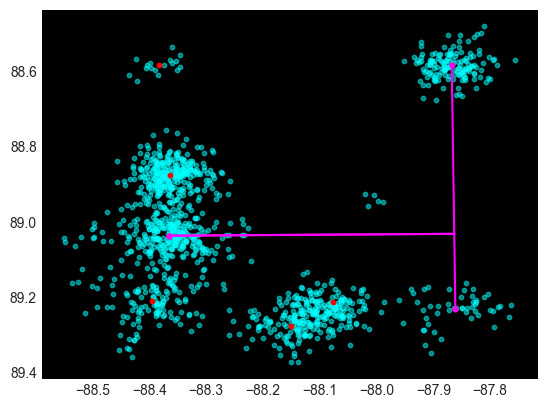

Closest line start: [41.63072705 90.99118359], end: [42.30375312 90.891319  ]
Initial calculated angle: -0.14730665735109602 radians (-8.440049760397565 degrees)
Adjusted angle by 90 degrees: 1.4234896694438006 radians (81.55995023960244 degrees)
Final rotation angle: -1.4234896694438006 radians (-81.55995023960244 degrees)


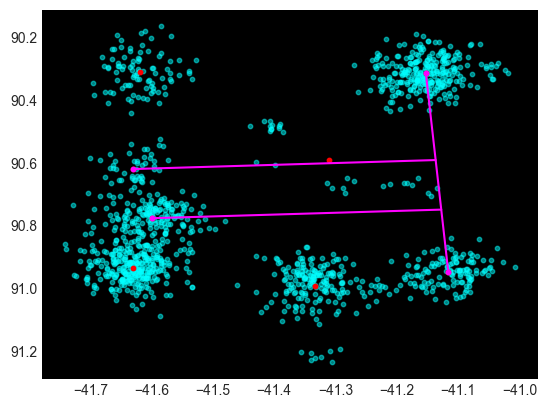

Closest line start: [29.8049068  89.65645588], end: [30.44936614 89.59924282]
Initial calculated angle: -0.08854471514473802 radians (-5.073238475981591 degrees)
Adjusted angle by 90 degrees: 1.4822516116501585 radians (84.9267615240184 degrees)
Final rotation angle: -1.4822516116501585 radians (-84.9267615240184 degrees)


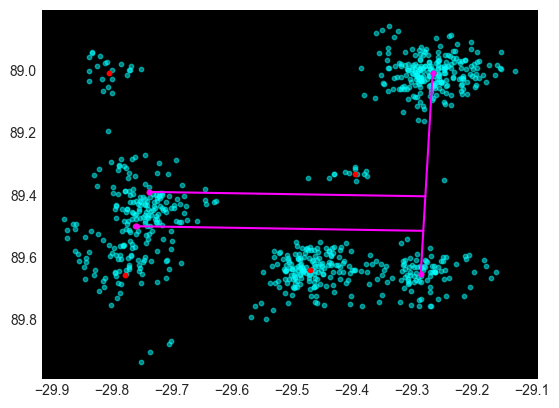

Closest line start: [19.51457063 99.83630994], end: [18.83726243 99.61790786]
Initial calculated angle: -2.8296634547248276 radians (-162.12777339814053 degrees)
Adjusted angle by 90 degrees: -1.258867127929931 radians (-72.12777339814053 degrees)
Final rotation angle: 1.258867127929931 radians (72.12777339814053 degrees)


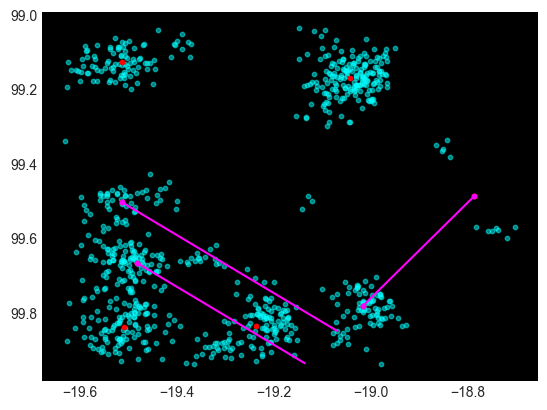

Closest line start: [ 15.74731055 107.84676647], end: [ 15.13833441 107.624988  ]
Initial calculated angle: -2.792339347730349 radians (-159.9892595932622 degrees)
Adjusted angle by 90 degrees: -1.2215430209354525 radians (-69.98925959326219 degrees)
Final rotation angle: 1.2215430209354525 radians (69.98925959326219 degrees)


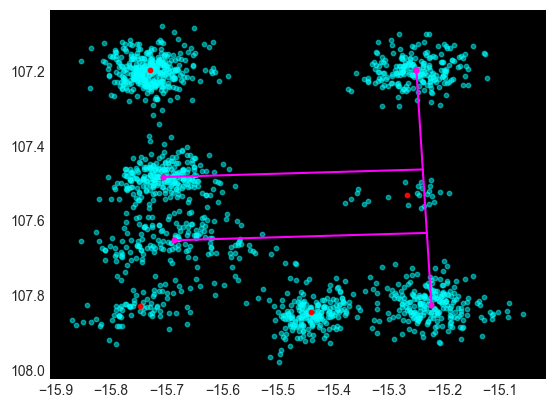

Closest line start: [ 17.52308903 105.11029411], end: [ 16.95758558 104.68286071]
Initial calculated angle: -2.4943607274104553 radians (-142.91634226380108 degrees)
Adjusted angle by 90 degrees: -0.9235644006155588 radians (-52.916342263801084 degrees)
Final rotation angle: 0.9235644006155588 radians (52.916342263801084 degrees)


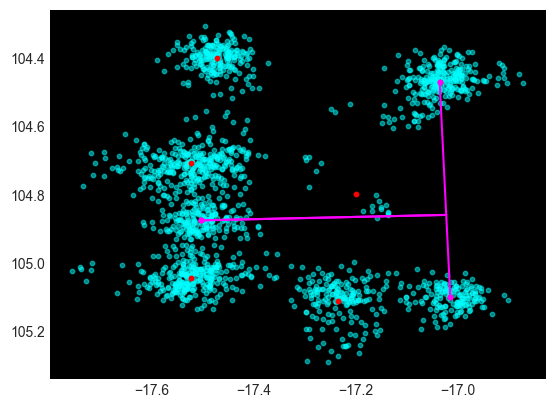

Closest line start: [ 22.81713668 101.73456496], end: [ 22.18328511 101.7117392 ]
Initial calculated angle: -3.1055969962384147 radians (-177.93760075296697 degrees)
Adjusted angle by 90 degrees: -1.5348006694435181 radians (-87.93760075296696 degrees)
Final rotation angle: 1.5348006694435181 radians (87.93760075296696 degrees)


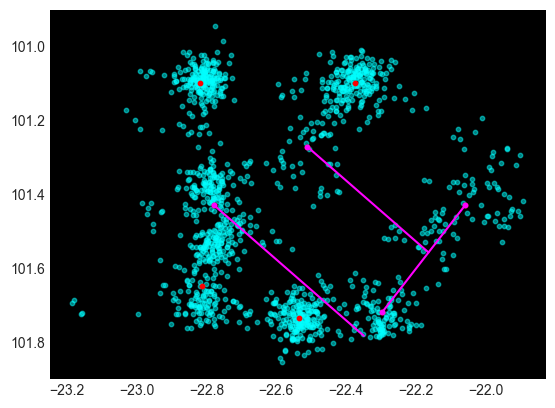

Closest line start: [106.88132911 109.9349797 ], end: [107.18056779 109.33517076]
Initial calculated angle: -1.1080371183773265 radians (-63.4858504268584 degrees)
Adjusted angle by 90 degrees: 0.46275920841757 radians (26.5141495731416 degrees)
Final rotation angle: -0.46275920841757 radians (-26.5141495731416 degrees)


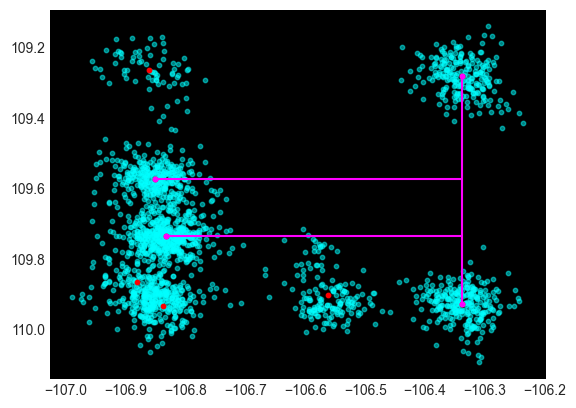

Closest line start: [166.90419865 107.30505689], end: [166.49650192 107.88777269]
Initial calculated angle: 2.181286914208452 radians (124.97853409125919 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.322879567798245 radians (304.9785340912592 degrees)
Final rotation angle: -5.322879567798245 radians (-304.9785340912592 degrees)


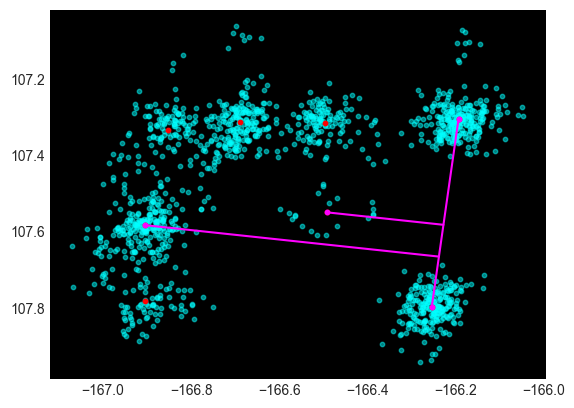

Closest line start: [216.7349116  108.39240697], end: [217.19448047 108.86518189]
Initial calculated angle: 0.7995615789075323 radians (45.811503932217946 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.9411542324973254 radians (225.81150393221793 degrees)
Final rotation angle: -3.9411542324973254 radians (-225.81150393221793 degrees)


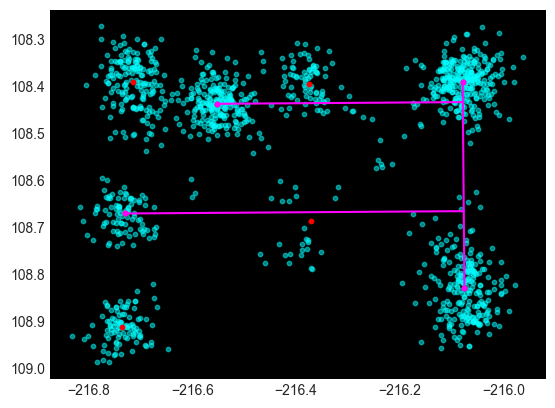

Closest line start: [194.25012589 117.07595603], end: [194.49045836 116.49375497]
Initial calculated angle: -1.1793045723421505 radians (-67.5691747556857 degrees)
Final rotation angle: 1.1793045723421505 radians (67.5691747556857 degrees)
Adjusting by 180 degrees


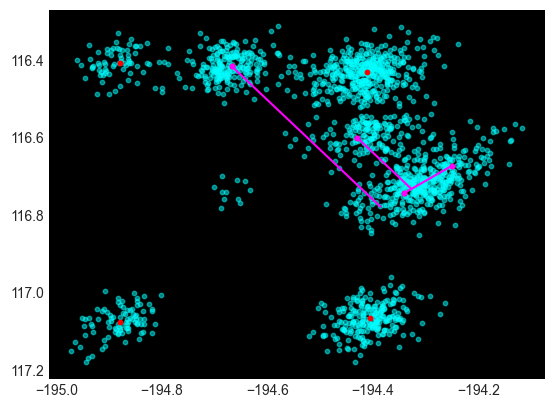

Closest line start: [168.48511594 113.87060213], end: [169.12719641 113.99399166]
Initial calculated angle: 0.1898568834834399 radians (10.877998135108134 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.331449537073233 radians (190.87799813510813 degrees)
Final rotation angle: -3.331449537073233 radians (-190.87799813510813 degrees)


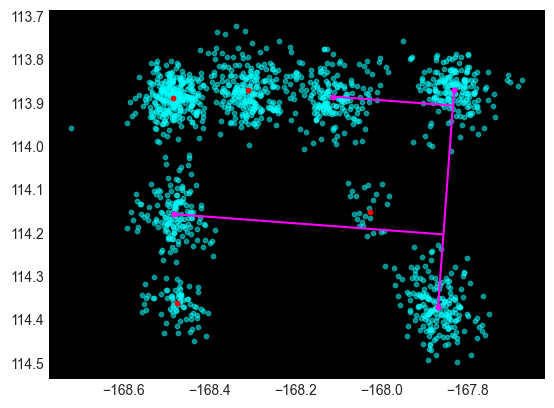

Closest line start: [154.6506968  109.10121982], end: [154.39789756 109.71137572]
Initial calculated angle: 1.963585479867338 radians (112.50516070956894 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.105178133457131 radians (292.50516070956894 degrees)
Final rotation angle: -5.105178133457131 radians (-292.50516070956894 degrees)


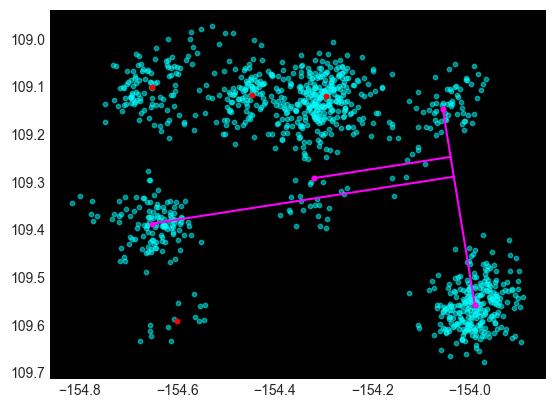

Closest line start: [148.69724582 112.56608241], end: [148.13946408 112.9857546 ]
Initial calculated angle: 2.496560511261301 radians (143.04238059429557 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.638153164851094 radians (323.04238059429554 degrees)
Final rotation angle: -5.638153164851094 radians (-323.04238059429554 degrees)


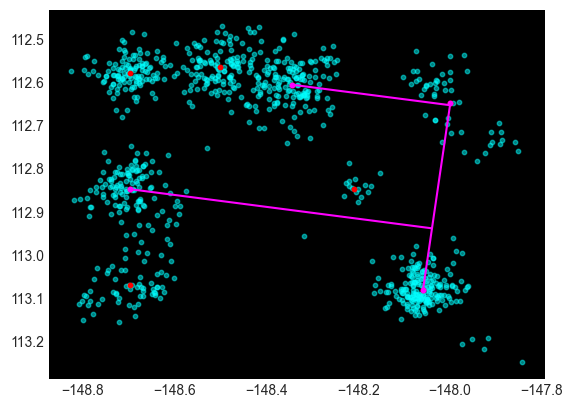

Closest line start: [150.45523183 121.04826498], end: [151.1181876  120.71091047]
Initial calculated angle: -0.47071385511406605 radians (-26.969917256368507 degrees)
Final rotation angle: 0.47071385511406605 radians (26.969917256368507 degrees)
Adjusting by 180 degrees


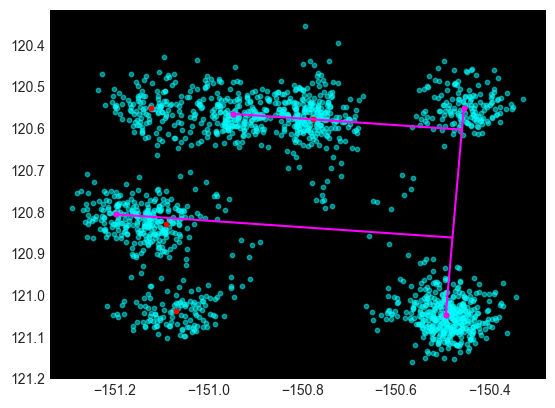

Closest line start: [144.30122276 119.63614798], end: [143.60559791 119.82580413]
Initial calculated angle: 2.8754205127359187 radians (164.74945970511132 degrees)
Adjusted angle by 180 degrees (for bottom side): 6.017013166325712 radians (344.7494597051113 degrees)
Final rotation angle: -6.017013166325712 radians (-344.7494597051113 degrees)


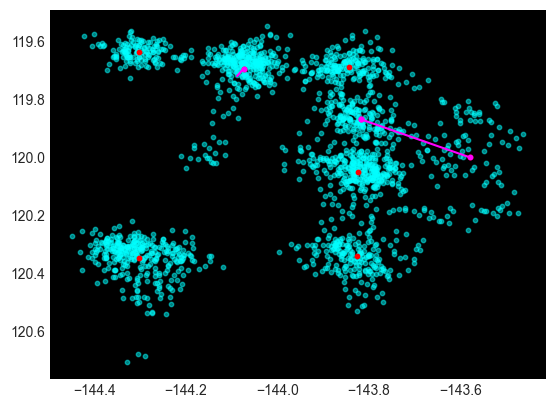

Closest line start: [130.50574045 119.41266817], end: [131.16463216 119.29300922]
Initial calculated angle: -0.17964848496419333 radians (-10.293099984367705 degrees)
Final rotation angle: 0.17964848496419333 radians (10.293099984367705 degrees)
Adjusting by 180 degrees


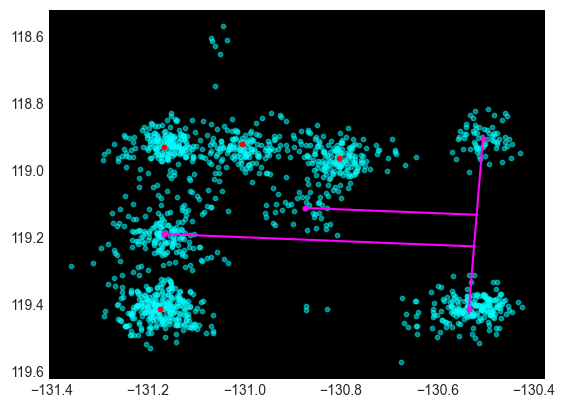

Closest line start: [ 54.06768377 120.48306353], end: [ 53.51625134 120.8567261 ]
Initial calculated angle: 2.5460441022911815 radians (145.87758151545916 degrees)
Adjusted angle by 90 degrees: 4.1168404290860785 radians (235.87758151545918 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.258433082675872 radians (415.87758151545916 degrees)
Final rotation angle: -7.258433082675872 radians (-415.87758151545916 degrees)


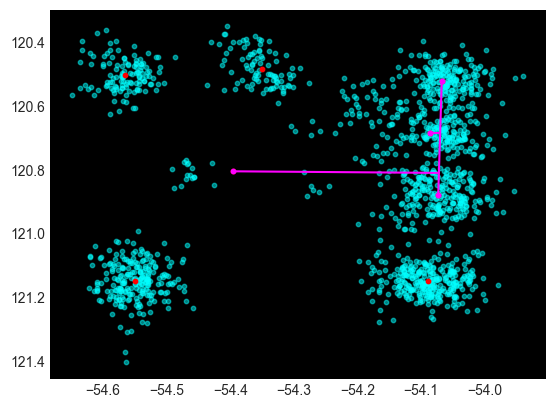

Closest line start: [ 22.30808424 120.29867878], end: [ 21.78275919 120.82456325]
Initial calculated angle: 2.3556623201947304 radians (134.96950890515322 degrees)
Adjusted angle by 90 degrees: 3.926458646989627 radians (224.96950890515322 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.06805130057942 radians (404.9695089051532 degrees)
Final rotation angle: -7.06805130057942 radians (-404.9695089051532 degrees)


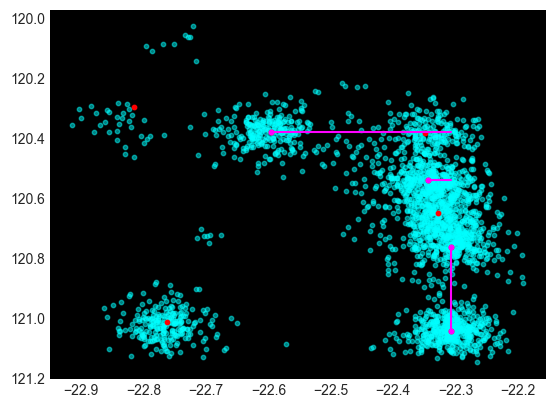

Closest line start: [199.99635236 129.19367258], end: [200.67959213 129.27675792]
Initial calculated angle: 0.12101079650230544 radians (6.933407915098566 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.2626034500920986 radians (186.93340791509857 degrees)
Final rotation angle: -3.2626034500920986 radians (-186.93340791509857 degrees)


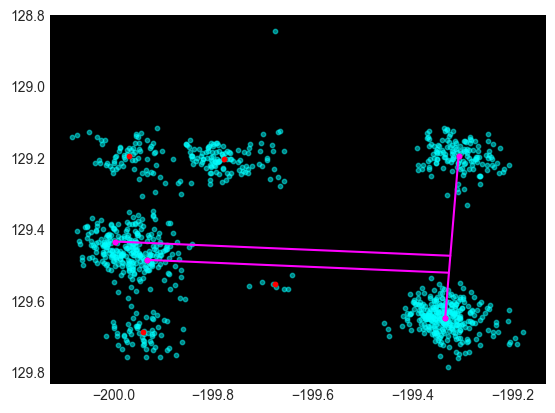

Closest line start: [222.16908466 124.13649717], end: [222.52836697 123.54931052]
Initial calculated angle: -1.0216940601099083 radians (-58.53875759788318 degrees)
Final rotation angle: 1.0216940601099083 radians (58.53875759788318 degrees)
Adjusting by 180 degrees


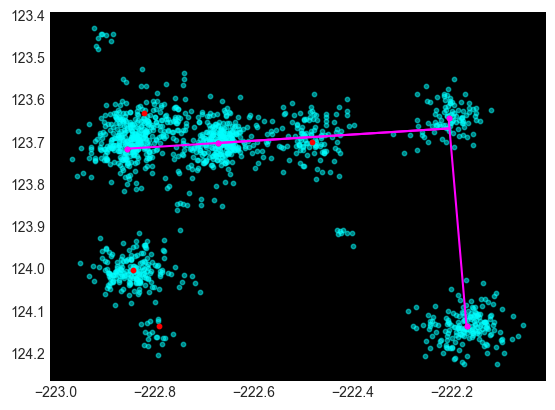

Closest line start: [229.4161776  129.25572381], end: [230.01604655 128.95543979]
Initial calculated angle: -0.4641136653520595 radians (-26.591754239020077 degrees)
Final rotation angle: 0.4641136653520595 radians (26.591754239020077 degrees)
Adjusting by 180 degrees


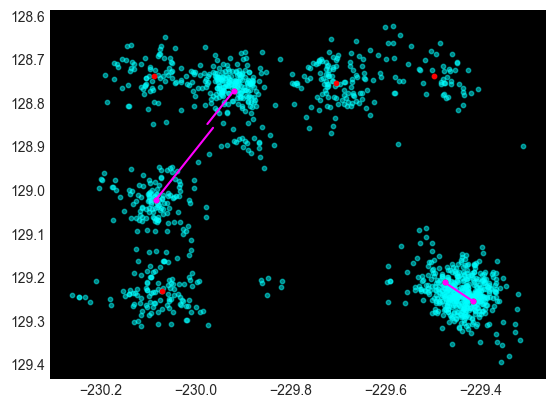

Closest line start: [239.65717712 122.91009816], end: [239.79290791 122.0887741 ]
Initial calculated angle: -1.4070180718512155 radians (-80.61619721570946 degrees)
Final rotation angle: 1.4070180718512155 radians (80.61619721570946 degrees)
Adjusting by 180 degrees


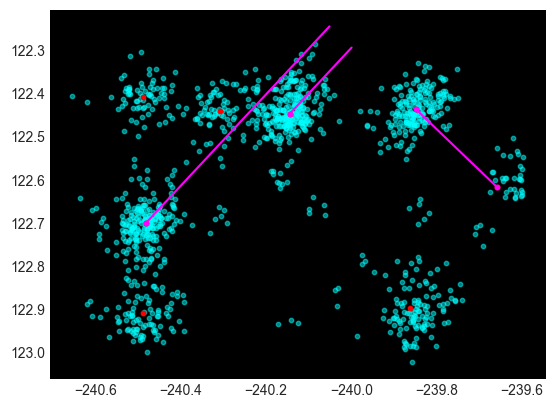

Closest line start: [206.22720831 148.78074076], end: [205.81435232 148.28592047]
Initial calculated angle: -2.266137486315714 radians (-129.84011376227576 degrees)
Final rotation angle: 2.266137486315714 radians (129.84011376227576 degrees)
Adjusting by 180 degrees


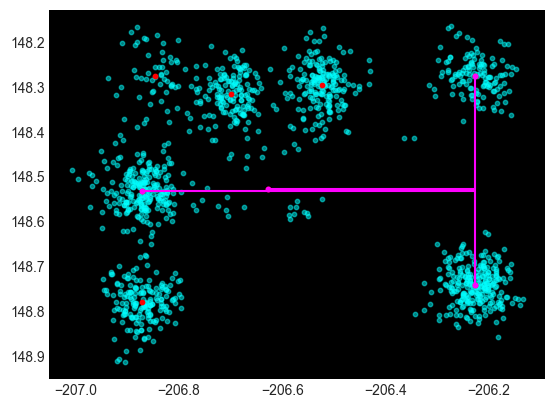

Closest line start: [181.83652341 147.30458871], end: [181.58041315 146.67286873]
Initial calculated angle: -1.9559641094907305 radians (-112.0684883528833 degrees)
Final rotation angle: 1.9559641094907305 radians (112.0684883528833 degrees)
Adjusting by 180 degrees


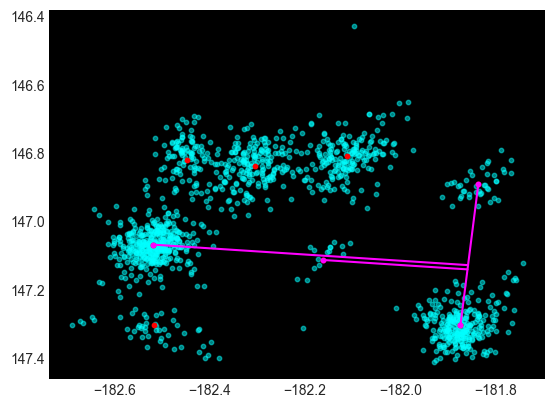

Closest line start: [150.18400111 140.74904871], end: [150.75263804 140.47798216]
Initial calculated angle: -0.444830634494386 radians (-25.48691795465485 degrees)
Final rotation angle: 0.444830634494386 radians (25.48691795465485 degrees)
Adjusting by 180 degrees


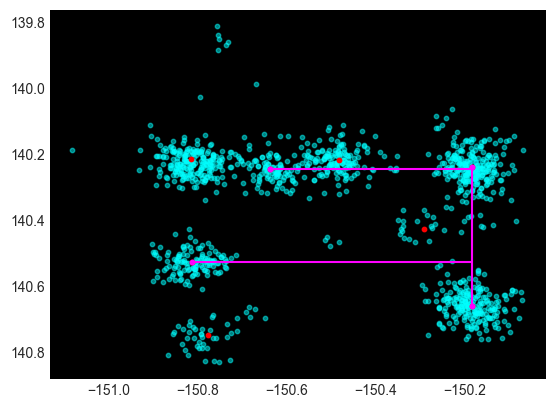

Closest line start: [ 79.60257404 148.43358411], end: [ 79.01499285 148.75958034]
Initial calculated angle: 2.635063647342577 radians (150.9780257410788 degrees)
Adjusted angle by 90 degrees: 4.205859974137473 radians (240.9780257410788 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.347452627727266 radians (420.9780257410788 degrees)
Final rotation angle: -7.347452627727266 radians (-420.9780257410788 degrees)


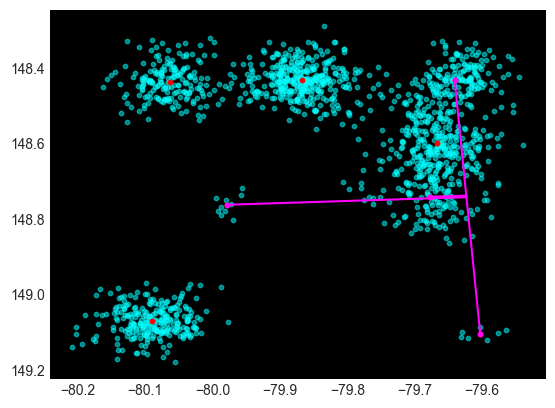

Closest line start: [ 40.33837502 141.27471705], end: [ 39.69368925 141.12937791]
Initial calculated angle: -2.919857713208624 radians (-167.2955237455741 degrees)
Adjusted angle by 90 degrees: -1.3490613864137275 radians (-77.29552374557409 degrees)
Final rotation angle: 1.3490613864137275 radians (77.29552374557409 degrees)


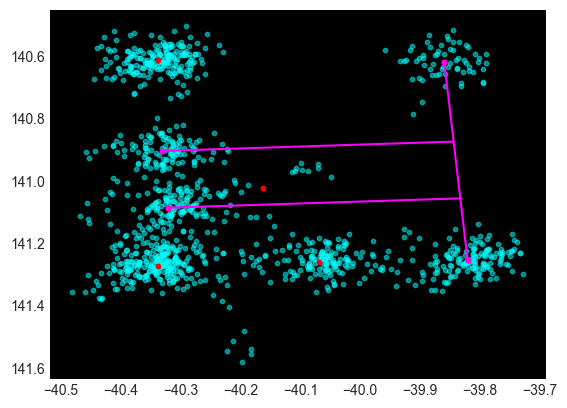

Closest line start: [ 28.55514237 142.15646214], end: [ 28.97166978 141.62555296]
Initial calculated angle: -0.9055443105775522 radians (-51.88386715817757 degrees)
Adjusted angle by 90 degrees: 0.6652520162173443 radians (38.11613284182243 degrees)
Final rotation angle: -0.6652520162173443 radians (-38.11613284182243 degrees)


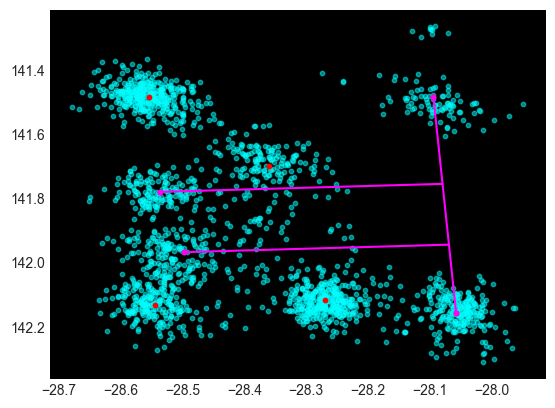

Closest line start: [ 16.57365969 167.47767403], end: [ 15.9140485  167.21423608]
Initial calculated angle: -2.761617695926427 radians (-158.22903860522698 degrees)
Adjusted angle by 90 degrees: -1.1908213691315304 radians (-68.22903860522698 degrees)
Final rotation angle: 1.1908213691315304 radians (68.22903860522698 degrees)


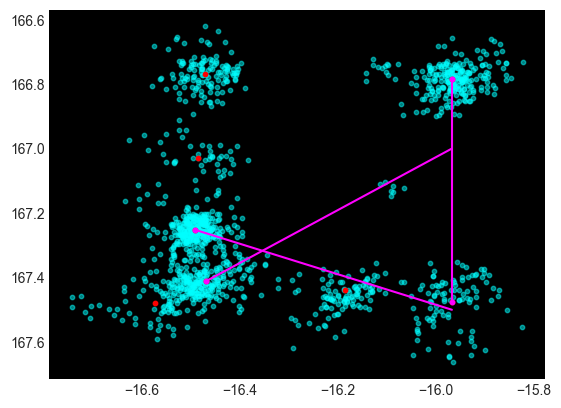

Closest line start: [ 23.37049342 146.53993108], end: [ 23.09943901 145.84008335]
Initial calculated angle: -1.9403109158597511 radians (-111.17162642192713 degrees)
Adjusted angle by 90 degrees: -0.36951458906485457 radians (-21.17162642192713 degrees)
Final rotation angle: 0.36951458906485457 radians (21.17162642192713 degrees)


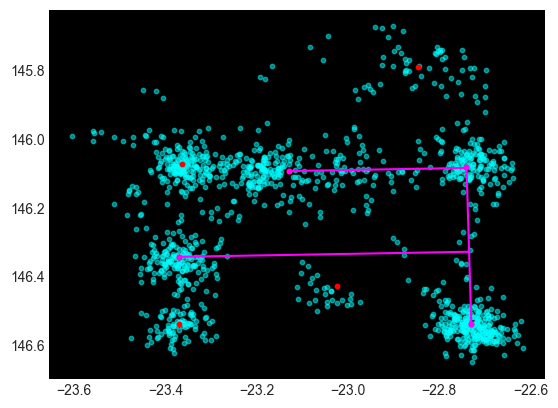

Closest line start: [ 96.72827711 150.00288321], end: [ 97.00423434 149.31151075]
Initial calculated angle: -1.1910280157293593 radians (-68.24087858313332 degrees)
Adjusted angle by 90 degrees: 0.3797683110655372 radians (21.75912141686668 degrees)
Final rotation angle: -0.3797683110655372 radians (-21.75912141686668 degrees)


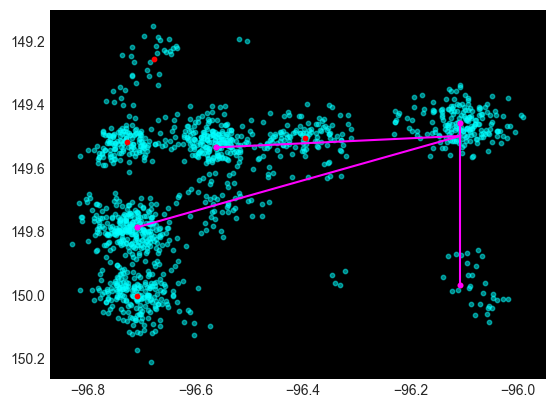

Closest line start: [120.44543128 156.63194315], end: [120.08250668 155.71499295]
Initial calculated angle: -1.947672741147376 radians (-111.59342794042071 degrees)
Adjusted angle by 90 degrees: -0.3768764143524794 radians (-21.593427940420714 degrees)
Final rotation angle: 0.3768764143524794 radians (21.593427940420714 degrees)


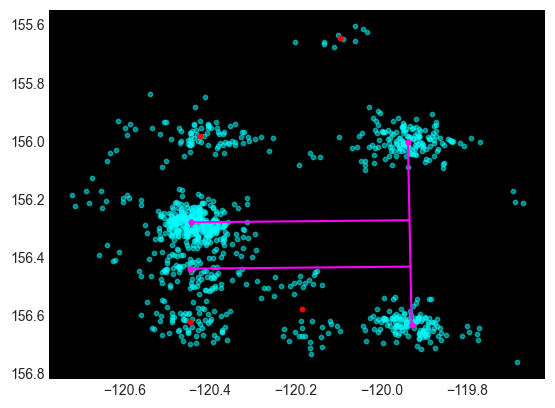

Closest line start: [146.58484529 150.55357281], end: [145.80579135 150.64819232]
Initial calculated angle: 3.0207302425026827 radians (173.0750939429334 degrees)
Adjusted angle by 90 degrees: 4.59152656929758 radians (263.07509394293345 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.733119222887373 radians (443.07509394293345 degrees)
Final rotation angle: -7.733119222887373 radians (-443.07509394293345 degrees)
Adjusting by 180 degrees


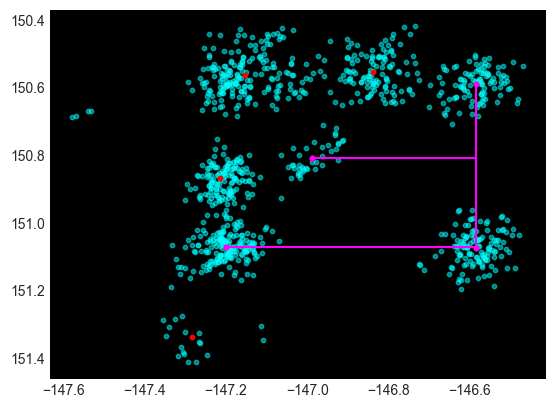

Closest line start: [232.29892463 156.19082569], end: [231.69500381 155.88473426]
Initial calculated angle: -2.672487757122555 radians (-153.12226928350583 degrees)
Final rotation angle: 2.672487757122555 radians (153.12226928350583 degrees)
Adjusting by 180 degrees


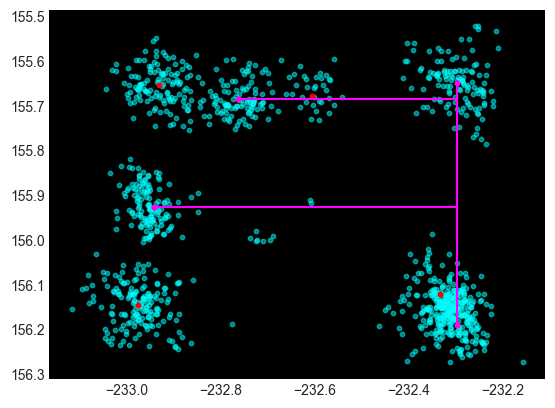

Closest line start: [242.43987503 162.29532414], end: [243.04057401 161.99868129]
Initial calculated angle: -0.45869900047186285 radians (-26.281516793907098 degrees)
Final rotation angle: 0.45869900047186285 radians (26.281516793907098 degrees)
Adjusting by 180 degrees


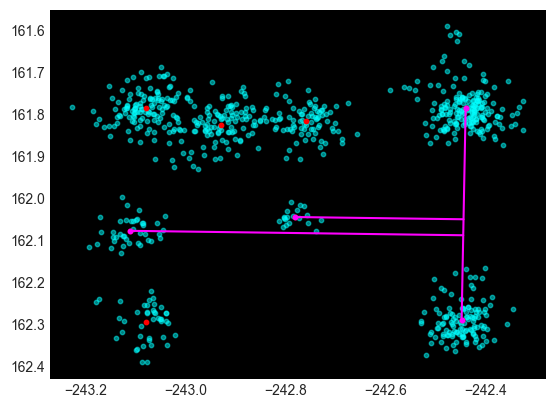

Closest line start: [236.27890266 168.16283657], end: [235.8974731  168.70232337]
Initial calculated angle: 2.186220163298937 radians (125.26118844343073 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.327812816888731 radians (305.26118844343074 degrees)
Final rotation angle: -5.327812816888731 radians (-305.26118844343074 degrees)


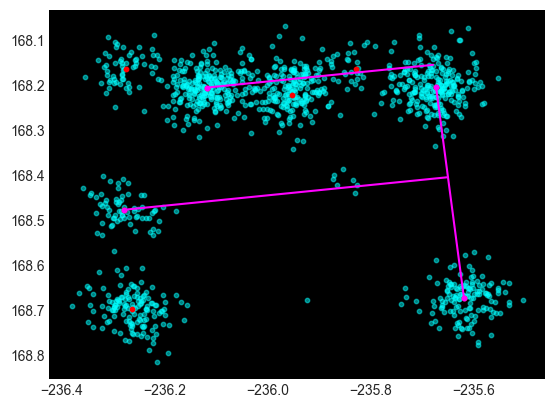

Closest line start: [235.96879225 170.78884862], end: [235.60043814 170.2703204 ]
Initial calculated angle: -2.188457418353578 radians (-125.38937371575597 degrees)
Final rotation angle: 2.188457418353578 radians (125.38937371575597 degrees)
Adjusting by 180 degrees


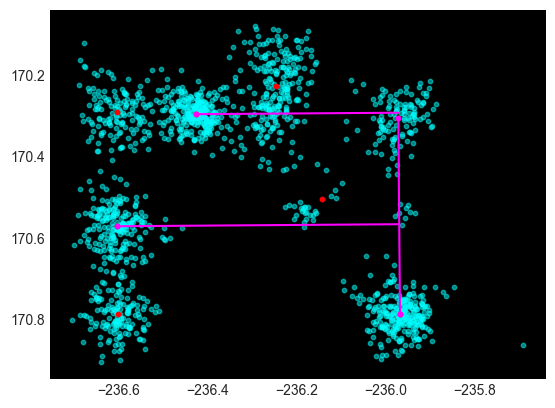

Closest line start: [204.90228191 184.53859604], end: [205.23731932 185.15300696]
Initial calculated angle: 1.0715698127446847 radians (61.39642772389436 degrees)
Adjusted angle by 180 degrees (for bottom side): 4.213162466334477 radians (241.39642772389433 degrees)
Final rotation angle: -4.213162466334477 radians (-241.39642772389433 degrees)


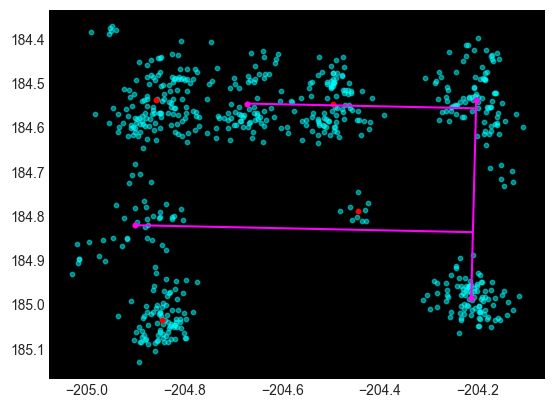

Closest line start: [206.46451849 172.53339769], end: [205.66696203 172.07022481]
Initial calculated angle: -2.615455361460155 radians (-149.85455371653006 degrees)
Final rotation angle: 2.615455361460155 radians (149.85455371653006 degrees)
Adjusting by 180 degrees


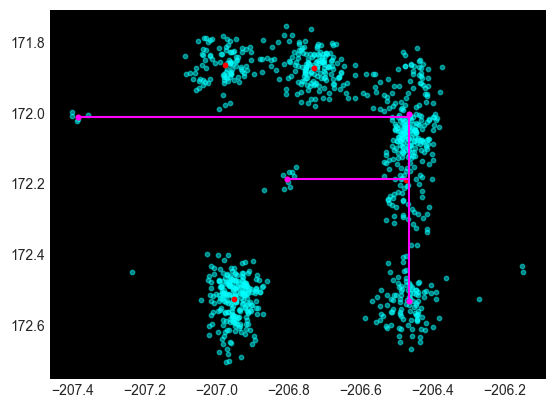

Closest line start: [153.65339993 178.02010873], end: [154.28766567 178.11166003]
Initial calculated angle: 0.14335209517323125 radians (8.21347003778385 degrees)
Adjusted angle by 90 degrees: 1.7141484219681278 radians (98.21347003778385 degrees)
Adjusted angle by 180 degrees (for bottom side): 4.855741075557921 radians (278.21347003778385 degrees)
Final rotation angle: -4.855741075557921 radians (-278.21347003778385 degrees)


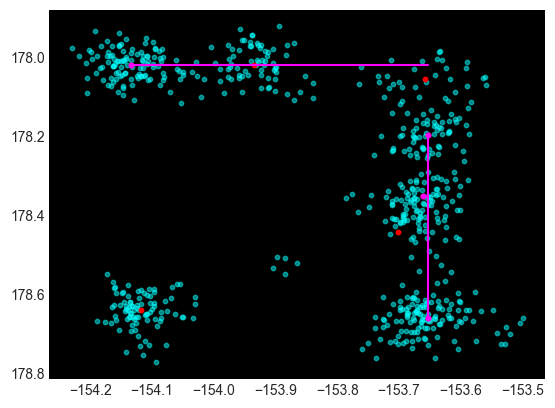

Closest line start: [120.25714191 173.20315603], end: [120.77110042 172.76995454]
Initial calculated angle: -0.7003415917790042 radians (-40.12661742641093 degrees)
Adjusted angle by 90 degrees: 0.8704547350158923 radians (49.87338257358906 degrees)
Final rotation angle: -0.8704547350158923 radians (-49.87338257358906 degrees)


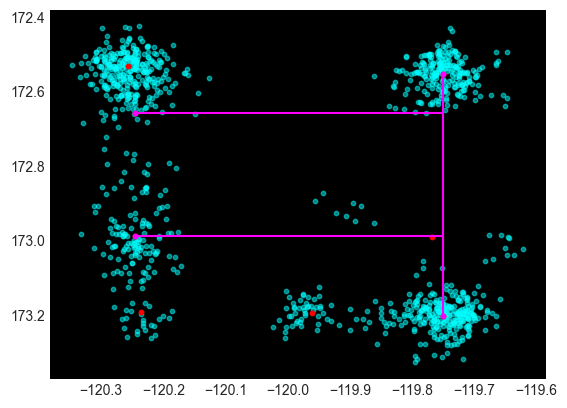

Closest line start: [ 56.5826201  181.17525004], end: [ 56.89225174 180.57215426]
Initial calculated angle: -1.0964833063838602 radians (-62.82386576234514 degrees)
Adjusted angle by 90 degrees: 0.4743130204110364 radians (27.176134237654857 degrees)
Final rotation angle: -0.4743130204110364 radians (-27.176134237654857 degrees)


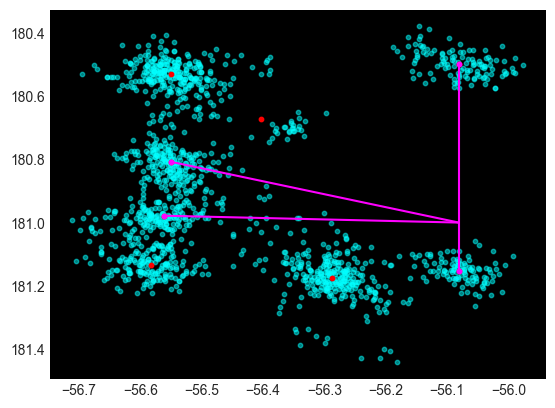

Closest line start: [ 50.00801034 175.98461142], end: [ 50.55264029 176.32503481]
Initial calculated angle: 0.5586384884418428 radians (32.00762766128541 degrees)
Adjusted angle by 90 degrees: 2.1294348152367393 radians (122.00762766128541 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.271027468826532 radians (302.0076276612854 degrees)
Final rotation angle: -5.271027468826532 radians (-302.0076276612854 degrees)


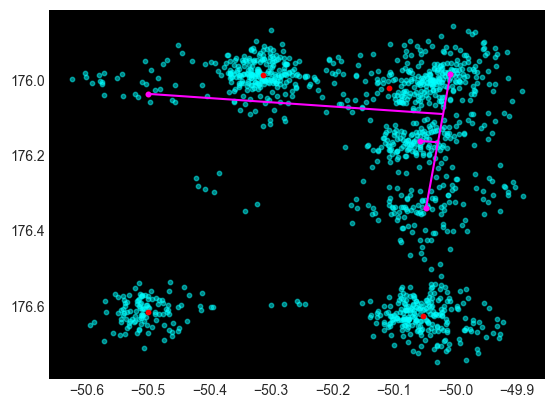

Closest line start: [ 42.18784587 169.70835226], end: [ 42.04449619 168.92126801]
Initial calculated angle: -1.7509492217218203 radians (-100.32200054637651 degrees)
Adjusted angle by 90 degrees: -0.18015289492692377 radians (-10.322000546376511 degrees)
Final rotation angle: 0.18015289492692377 radians (10.322000546376511 degrees)


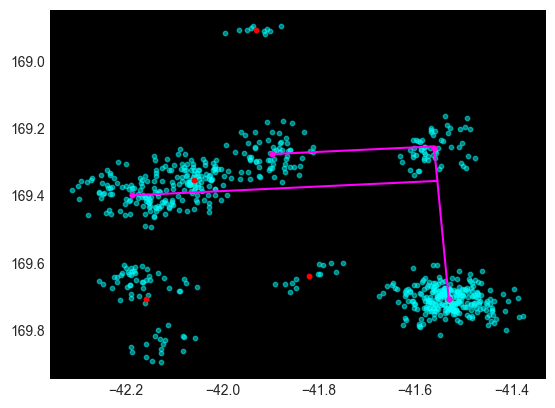

Closest line start: [ 75.52060135 191.90000665], end: [ 74.99084345 191.48335942]
Initial calculated angle: -2.4751463866651604 radians (-141.81544163296942 degrees)
Adjusted angle by 90 degrees: -0.9043500598702638 radians (-51.81544163296944 degrees)
Final rotation angle: 0.9043500598702638 radians (51.81544163296944 degrees)
Adjusting by 180 degrees


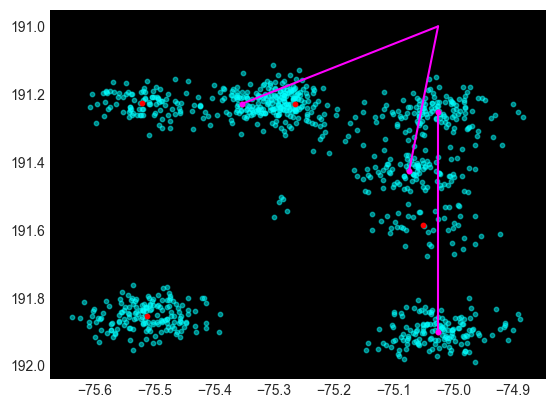

Closest line start: [ 77.98718209 194.27839909], end: [ 78.54694028 194.61690143]
Initial calculated angle: 0.5438898839785552 radians (31.162594871831224 degrees)
Adjusted angle by 90 degrees: 2.114686210773452 radians (121.16259487183123 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.256278864363245 radians (301.16259487183123 degrees)
Final rotation angle: -5.256278864363245 radians (-301.16259487183123 degrees)
Adjusting by 180 degrees


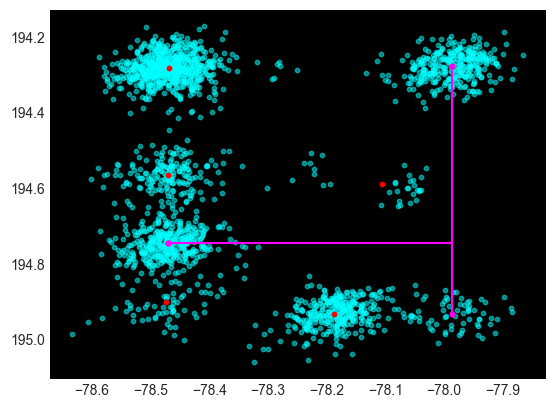

Closest line start: [112.05139826 190.29500247], end: [112.73891062 190.32625886]
Initial calculated angle: 0.04543172806243581 radians (2.603046273963637 degrees)
Adjusted angle by 90 degrees: 1.6162280548573325 radians (92.60304627396364 degrees)
Adjusted angle by 180 degrees (for bottom side): 4.757820708447126 radians (272.6030462739636 degrees)
Final rotation angle: -4.757820708447126 radians (-272.6030462739636 degrees)


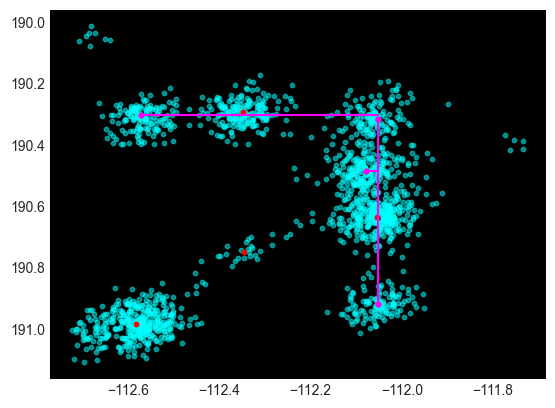

Closest line start: [115.35499663 193.58876837], end: [114.73739652 193.83449498]
Initial calculated angle: 2.7629209535986425 radians (158.30370976946298 degrees)
Adjusted angle by 90 degrees: 4.3337172803935395 radians (248.303709769463 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.475309933983333 radians (428.303709769463 degrees)
Final rotation angle: -7.475309933983333 radians (-428.303709769463 degrees)


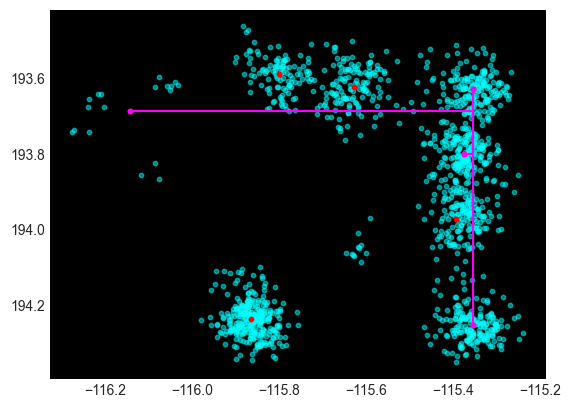

Closest line start: [144.67993213 186.34892132], end: [145.23964985 185.97411241]
Initial calculated angle: -0.5900576711611549 radians (-33.807814226852365 degrees)
Adjusted angle by 90 degrees: 0.9807386556337416 radians (56.192185773147635 degrees)
Final rotation angle: -0.9807386556337416 radians (-56.192185773147635 degrees)


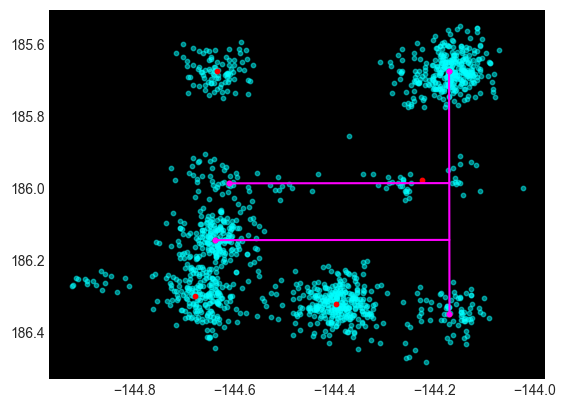

Closest line start: [156.61260913 196.73853688], end: [157.23786178 196.50121919]
Initial calculated angle: -0.362757986011826 radians (-20.784501583143385 degrees)
Adjusted angle by 90 degrees: 1.2080383407830706 radians (69.21549841685662 degrees)
Final rotation angle: -1.2080383407830706 radians (-69.21549841685662 degrees)
Adjusting by 180 degrees


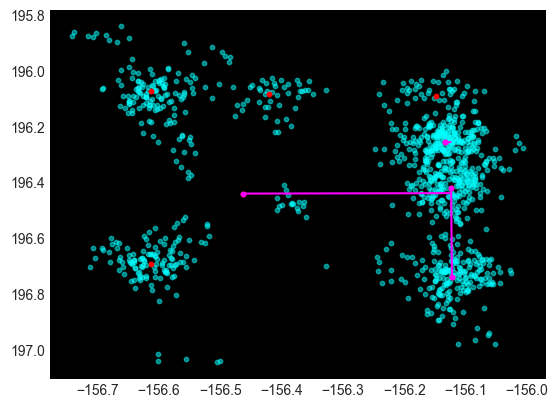

Closest line start: [224.89041086 205.36409544], end: [225.54485045 205.65810817]
Initial calculated angle: 0.42223735775155175 radians (24.19241855191937 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.563830011341345 radians (204.1924185519194 degrees)
Final rotation angle: -3.563830011341345 radians (-204.1924185519194 degrees)


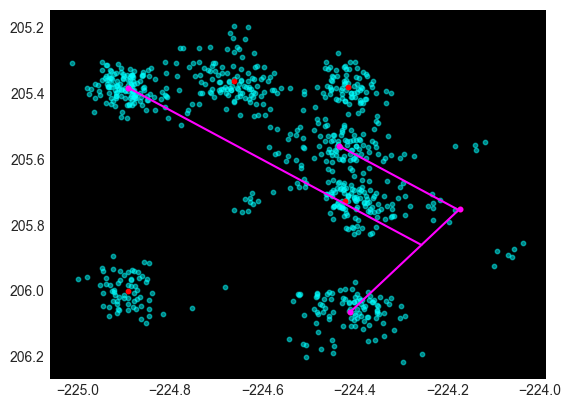

Closest line start: [114.36136385 210.83328618], end: [113.68458419 211.03563019]
Initial calculated angle: 2.8510713234379943 radians (163.35435392377514 degrees)
Adjusted angle by 90 degrees: 4.42186765023289 radians (253.3543539237751 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.5634603038226835 radians (433.35435392377514 degrees)
Final rotation angle: -7.5634603038226835 radians (-433.35435392377514 degrees)


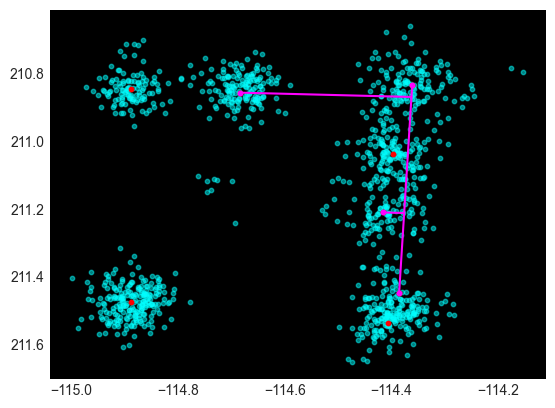

Closest line start: [109.99100208 219.82046887], end: [110.63255695 220.02020181]
Initial calculated angle: 0.3018152805736101 radians (17.292741769424644 degrees)
Adjusted angle by 90 degrees: 1.8726116073685066 radians (107.29274176942464 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.0142042609583 radians (287.29274176942465 degrees)
Final rotation angle: -5.0142042609583 radians (-287.29274176942465 degrees)


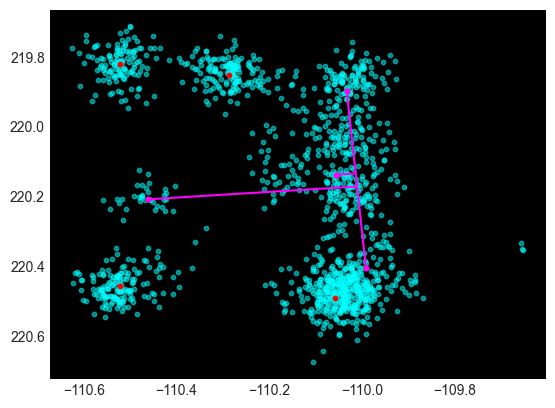

Closest line start: [ 81.27328951 207.330808  ], end: [ 80.66580751 207.83558874]
Initial calculated angle: 2.448268847528774 radians (140.27547207675678 degrees)
Adjusted angle by 90 degrees: 4.0190651743236705 radians (230.27547207675678 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.160657827913464 radians (410.2754720767568 degrees)
Final rotation angle: -7.160657827913464 radians (-410.2754720767568 degrees)


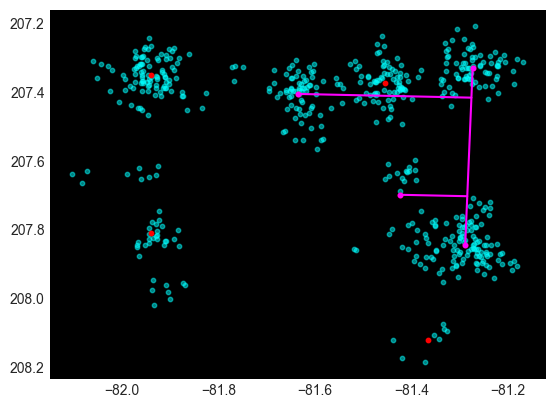

Closest line start: [ 50.4446279  203.50967269], end: [ 49.87439426 203.14187483]
Initial calculated angle: -2.5687439297846164 radians (-147.178185826508 degrees)
Adjusted angle by 90 degrees: -0.9979476029897199 radians (-57.178185826508 degrees)
Final rotation angle: 0.9979476029897199 radians (57.178185826508 degrees)


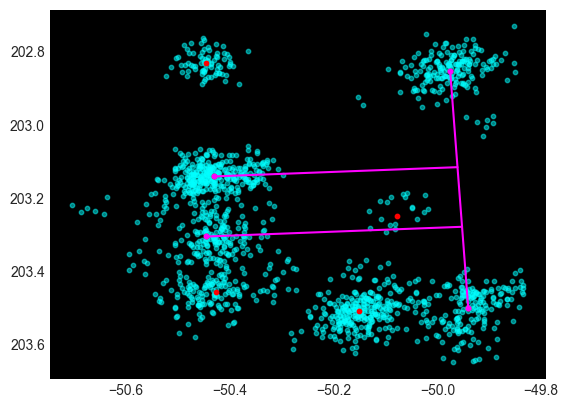

Closest line start: [ 46.68606484 214.87158659], end: [ 46.23649761 215.38041661]
Initial calculated angle: 2.2944378150838856 radians (131.46160315952466 degrees)
Adjusted angle by 90 degrees: 3.865234141878782 radians (221.46160315952466 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.006826795468575 radians (401.46160315952466 degrees)
Final rotation angle: -7.006826795468575 radians (-401.46160315952466 degrees)


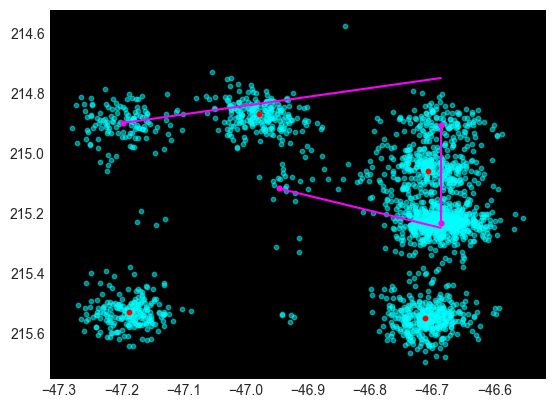

Closest line start: [ 21.60572123 234.0257397 ], end: [ 20.95331313 233.9266272 ]
Initial calculated angle: -2.9908274913197115 radians (-171.3617925043193 degrees)
Adjusted angle by 90 degrees: -1.420031164524815 radians (-81.36179250431933 degrees)
Final rotation angle: 1.420031164524815 radians (81.36179250431933 degrees)


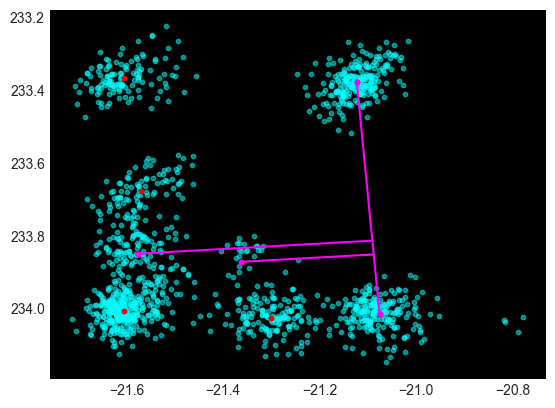

Closest line start: [ 53.54908327 237.26350755], end: [ 53.69715123 237.88756677]
Initial calculated angle: 1.3378381512298292 radians (76.65247973705398 degrees)
Adjusted angle by 90 degrees: 2.9086344780247257 radians (166.65247973705397 degrees)
Adjusted angle by 180 degrees (for bottom side): 6.050227131614519 radians (346.65247973705397 degrees)
Final rotation angle: -6.050227131614519 radians (-346.65247973705397 degrees)


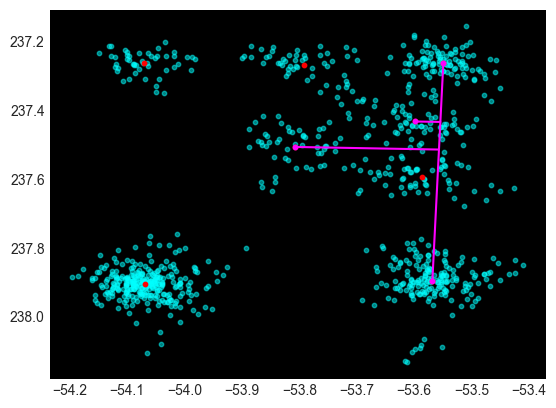

Closest line start: [ 96.41143121 226.63702599], end: [ 96.9560637  227.26413144]
Initial calculated angle: 0.8556674245181758 radians (49.02613209172041 degrees)
Adjusted angle by 90 degrees: 2.4264637513130722 radians (139.0261320917204 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.568056404902865 radians (319.0261320917204 degrees)
Final rotation angle: -5.568056404902865 radians (-319.0261320917204 degrees)
Adjusting by 180 degrees


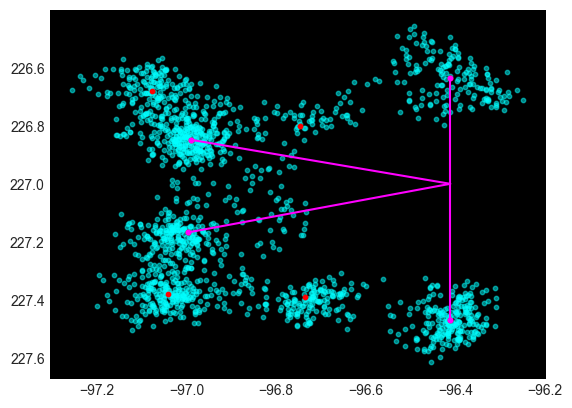

Closest line start: [131.51286181 223.16053768], end: [131.07471287 222.69101975]
Initial calculated angle: -2.321648219835408 radians (-133.0206445106296 degrees)
Adjusted angle by 90 degrees: -0.7508518930405113 radians (-43.0206445106296 degrees)
Final rotation angle: 0.7508518930405113 radians (43.0206445106296 degrees)


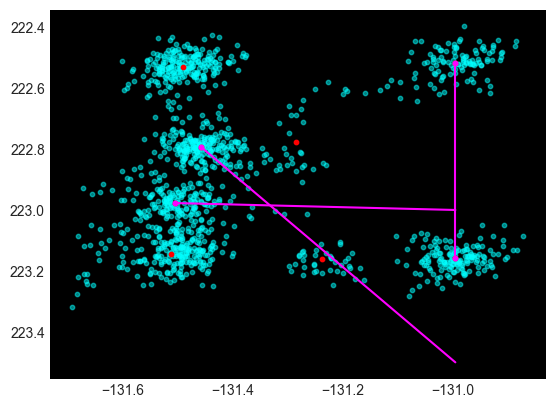

Closest line start: [157.0346625  233.22660547], end: [156.40144564 232.86267964]
Initial calculated angle: -2.619964746622043 radians (-150.11292245450517 degrees)
Adjusted angle by 90 degrees: -1.0491684198271463 radians (-60.11292245450516 degrees)
Final rotation angle: 1.0491684198271463 radians (60.11292245450516 degrees)


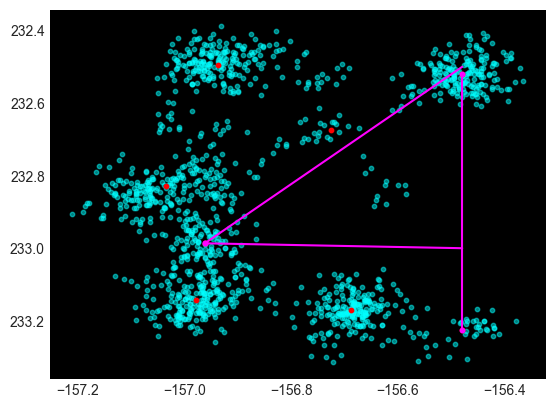

Closest line start: [215.48902071 223.13922355], end: [215.85626607 222.57596699]
Initial calculated angle: -0.9930138242090236 radians (-56.89550112532291 degrees)
Adjusted angle by 90 degrees: 0.5777825025858729 radians (33.10449887467709 degrees)
Final rotation angle: -0.5777825025858729 radians (-33.10449887467709 degrees)


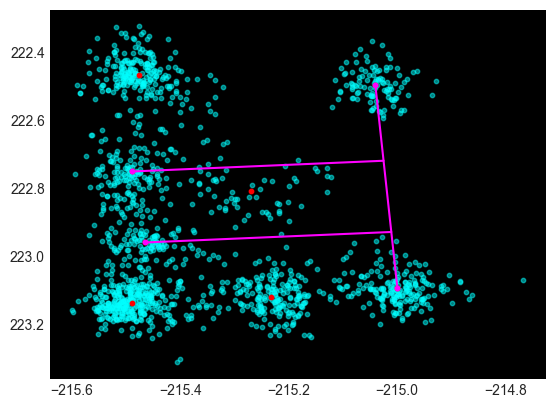

Closest line start: [196.1066882  225.77804489], end: [196.00890608 225.1030295 ]
Initial calculated angle: -1.7146547434118793 radians (-98.24248011958778 degrees)
Adjusted angle by 90 degrees: -0.14385841661698273 radians (-8.24248011958778 degrees)
Final rotation angle: 0.14385841661698273 radians (8.24248011958778 degrees)


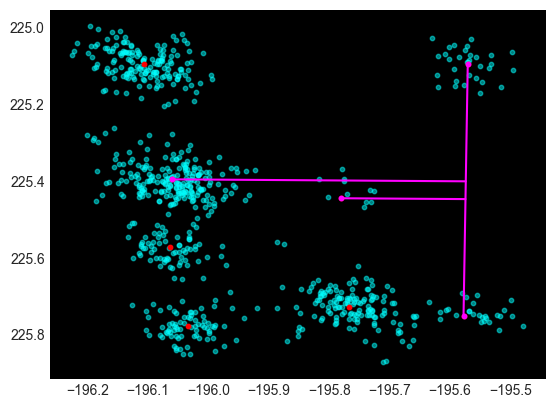

Closest line start: [186.33273769 237.86649913], end: [186.00427729 238.44001798]
Initial calculated angle: 2.0909084554037314 radians (119.80022984285172 degrees)
Adjusted angle by 90 degrees: 3.661704782198628 radians (209.8002298428517 degrees)
Adjusted angle by 180 degrees (for bottom side): 6.803297435788421 radians (389.8002298428517 degrees)
Final rotation angle: -6.803297435788421 radians (-389.8002298428517 degrees)


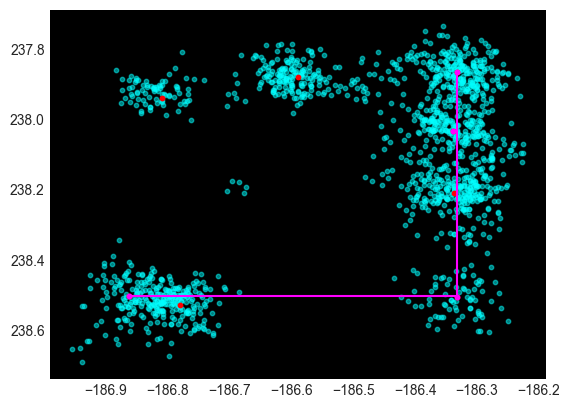

Closest line start: [180.96336401 229.15201666], end: [180.79539113 228.50785212]
Initial calculated angle: -1.8258769069810963 radians (-104.61504068041762 degrees)
Adjusted angle by 90 degrees: -0.2550805801861997 radians (-14.615040680417614 degrees)
Final rotation angle: 0.2550805801861997 radians (14.615040680417614 degrees)


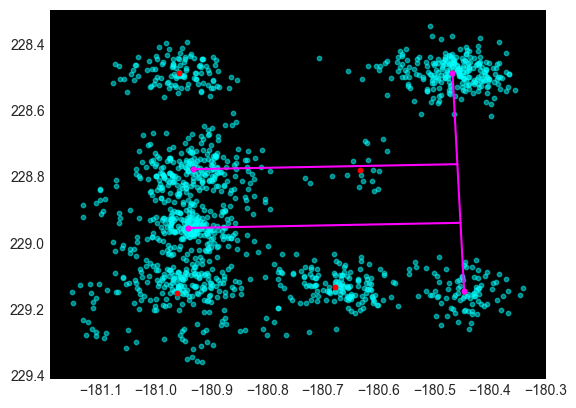

Closest line start: [177.45160365 225.53419065], end: [177.84252976 226.07798863]
Initial calculated angle: 0.9475105385637551 radians (54.2883549038708 degrees)
Adjusted angle by 90 degrees: 2.518306865358652 radians (144.2883549038708 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.6598995189484445 radians (324.28835490387075 degrees)
Final rotation angle: -5.6598995189484445 radians (-324.28835490387075 degrees)


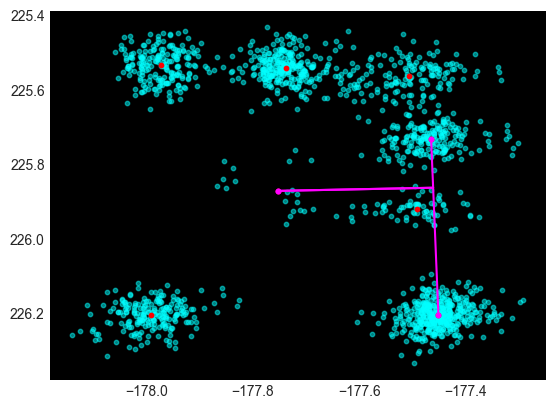

Closest line start: [161.12991069 246.39845453], end: [160.55183564 246.75686286]
Initial calculated angle: 2.586594678960613 radians (148.20095841543923 degrees)
Adjusted angle by 90 degrees: 4.1573910057555095 radians (238.20095841543923 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.298983659345303 radians (418.20095841543923 degrees)
Final rotation angle: -7.298983659345303 radians (-418.20095841543923 degrees)


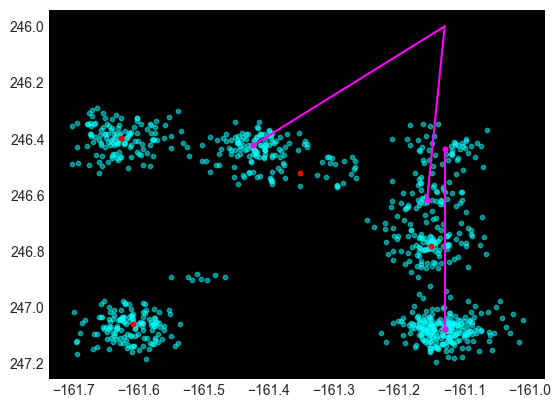

Closest line start: [136.42256638 249.43508142], end: [136.31000158 248.78258   ]
Initial calculated angle: -1.7416276178103032 radians (-99.78791198395393 degrees)
Adjusted angle by 90 degrees: -0.17083129101540662 radians (-9.787911983953938 degrees)
Final rotation angle: 0.17083129101540662 radians (9.787911983953938 degrees)


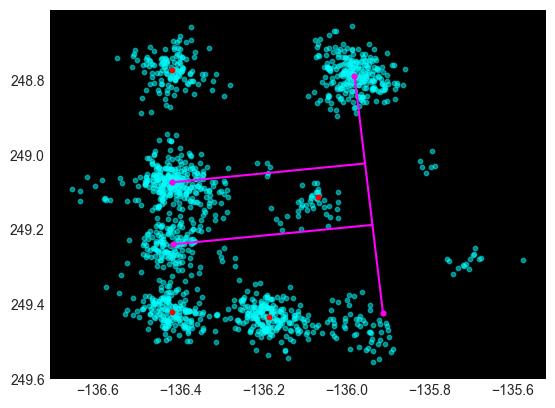

Closest line start: [ 65.82079277 244.57944451], end: [ 66.07940306 245.17728336]
Initial calculated angle: 1.1625269111219791 radians (66.60788557766956 degrees)
Adjusted angle by 90 degrees: 2.733323237916876 radians (156.60788557766958 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.874915891506669 radians (336.6078855776696 degrees)
Final rotation angle: -5.874915891506669 radians (-336.6078855776696 degrees)


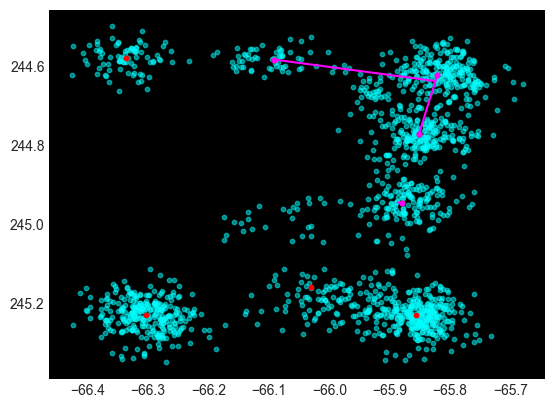

Closest line start: [ 16.15907693 246.67529817], end: [ 15.57892152 247.13131924]
Initial calculated angle: 2.47542663522795 radians (141.83149869283187 degrees)
Adjusted angle by 90 degrees: 4.0462229620228465 radians (231.83149869283187 degrees)
Adjusted angle by 180 degrees (for bottom side): 7.18781561561264 radians (411.8314986928319 degrees)
Final rotation angle: -7.18781561561264 radians (-411.8314986928319 degrees)


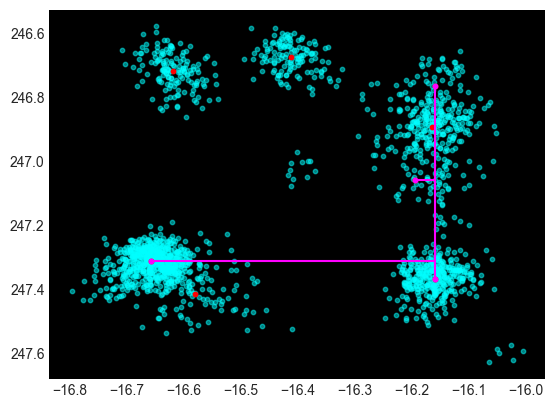

Closest line start: [195.3291679   6.702311 ], end: [194.45355088   6.58287786]
Initial calculated angle: -3.0060303844940965 radians (-172.23285411959984 degrees)
Final rotation angle: 3.0060303844940965 radians (172.23285411959984 degrees)
Adjusting by 180 degrees


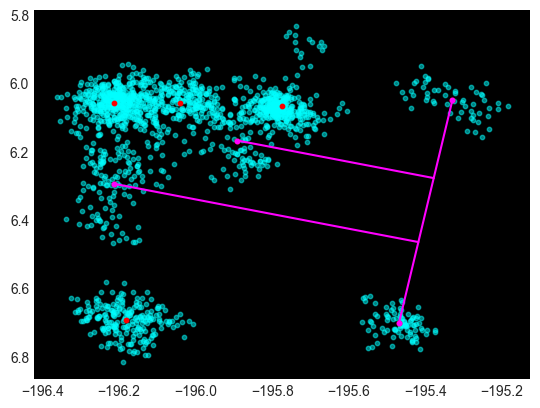

Closest line start: [37.5321137  73.74764455], end: [38.10085447 74.09670743]
Initial calculated angle: 0.5504662438853266 radians (31.539392539048276 degrees)
Adjusted angle by 90 degrees: 2.1212625706802233 radians (121.53939253904828 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.262855224270016 radians (301.53939253904827 degrees)
Final rotation angle: -5.262855224270016 radians (-301.53939253904827 degrees)


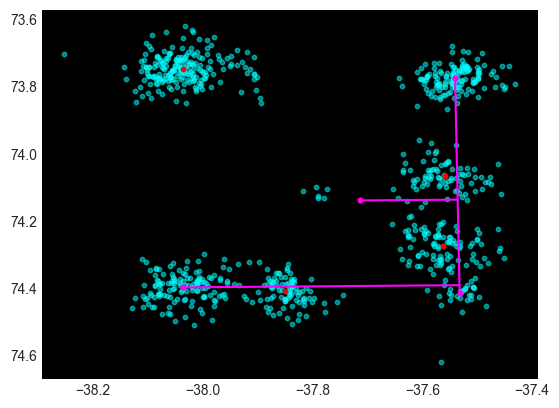

Closest line start: [167.92625995 198.5320282 ], end: [168.55002846 198.75473464]
Initial calculated angle: 0.34292721709723584 radians (19.64828221983814 degrees)
Adjusted angle by 90 degrees: 1.9137235438921323 radians (109.64828221983814 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.055316197481925 radians (289.6482822198381 degrees)
Final rotation angle: -5.055316197481925 radians (-289.6482822198381 degrees)


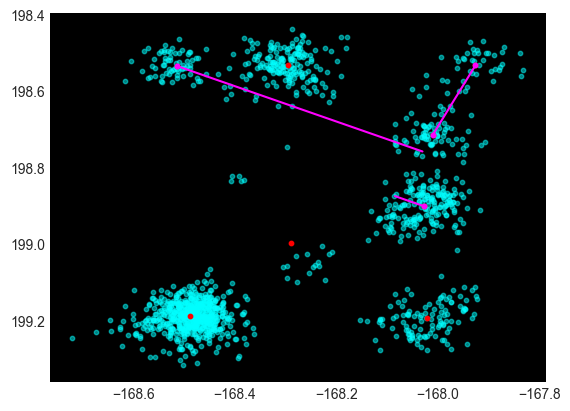

Closest line start: [ 76.08309678 193.53710094], end: [ 76.08970395 194.18867932]
Initial calculated angle: 1.5606564288319171 radians (89.41902664202797 degrees)
Adjusted angle by 90 degrees: 3.131452755626814 radians (179.419026642028 degrees)
Adjusted angle by 180 degrees (for bottom side): 6.273045409216607 radians (359.419026642028 degrees)
Final rotation angle: -6.273045409216607 radians (-359.419026642028 degrees)


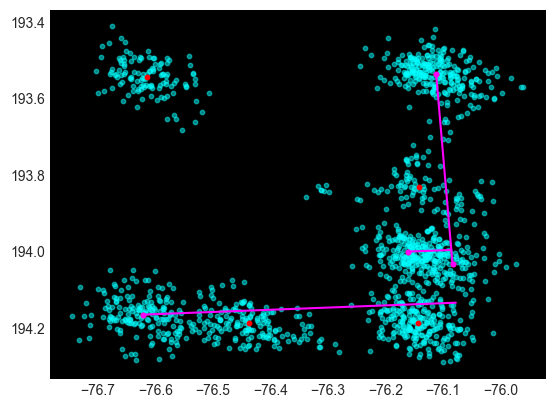

Closest line start: [ 47.33071759 217.77178953], end: [ 47.94697397 217.52796144]
Initial calculated angle: -0.37675954968653047 radians (-21.586732088287633 degrees)
Adjusted angle by 90 degrees: 1.1940367771083662 radians (68.41326791171237 degrees)
Final rotation angle: -1.1940367771083662 radians (-68.41326791171237 degrees)


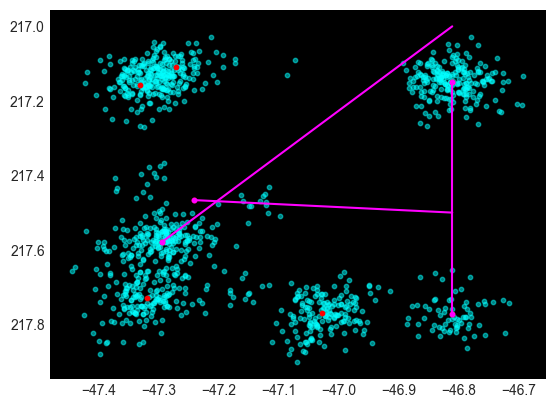

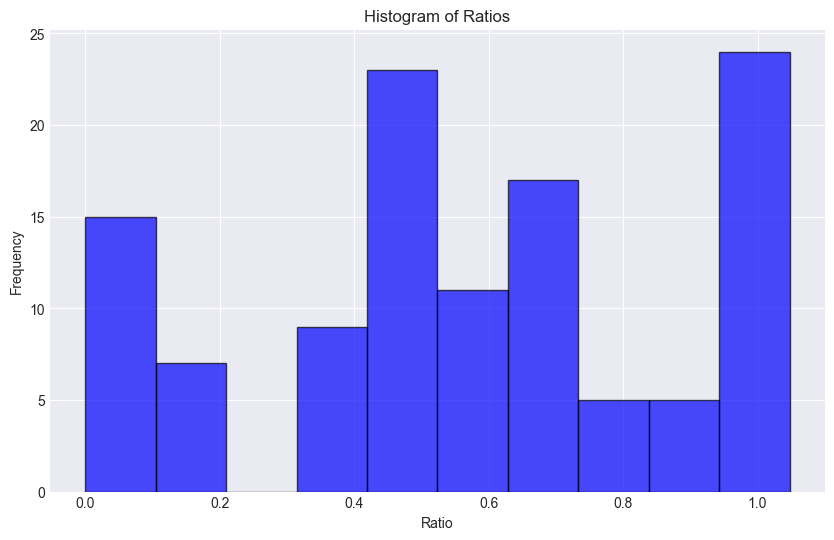

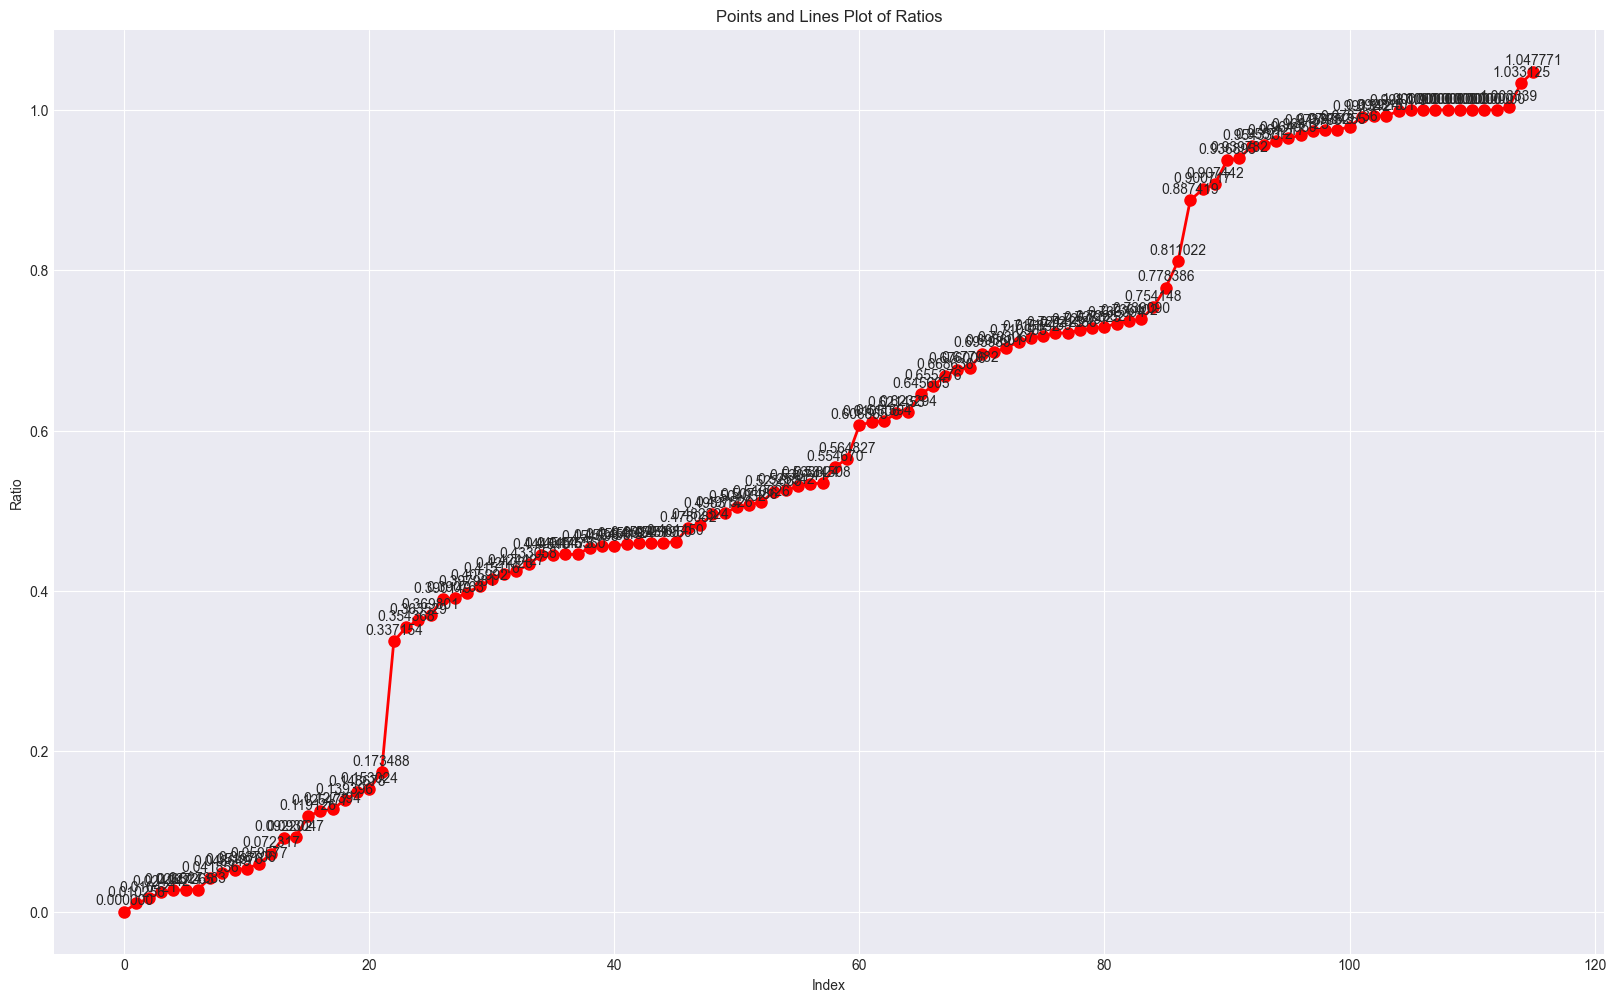

Mean Ratio: 0.5705002871269788
Standard Deviation: 0.31376968067147315


[0.0,
 0.010255709696992995,
 0.01642132405994713,
 0.024242159604352116,
 0.026513936308153397,
 0.027264865935666176,
 0.027383257715764386,
 0.04185556779061619,
 0.048649485358571526,
 0.05197608454614107,
 0.053706122738513905,
 0.05957728976130118,
 0.07231676926401942,
 0.09220163394948754,
 0.0930465583373873,
 0.11912568738880978,
 0.12547655870933316,
 0.12739368394253242,
 0.13939612525077677,
 0.14867776122153578,
 0.15302398021617147,
 0.17348772279334626,
 0.33715430093562226,
 0.3543682959195461,
 0.36352898681684614,
 0.3698005659422285,
 0.3901489840572745,
 0.3907628419994574,
 0.3979810841908911,
 0.40599238453624037,
 0.4151156178573758,
 0.4210231587200302,
 0.4244266832703412,
 0.43305783909643825,
 0.4445101605646166,
 0.44517451516358375,
 0.4454750601867347,
 0.4455599116772169,
 0.45409277117523594,
 0.45544956894272964,
 0.45641518798128283,
 0.4580240834520288,
 0.4592706852001739,
 0.45956753383714677,
 0.4599501584406917,
 0.46144950711700106,
 0.478082308

In [20]:
# Example usage
filename = 'data\csdna_v8_no_inhibitor_1nM_20nm_grid_0.5nM_HM_t=0_82324_T3_locs_render_picked_refined.hdf5'
k = 8
process_multiple_origami_ratio(filename, k, flipped=True)

In [ ]:
ratio = process_origami_ratio('data/csDNA_v8_1nM_20nm_0.5nM_TT1_3_to_5_pos_ctrl_rayhan_8724_T2_cropped_locs_picked.hdf5', 8)